In [2]:
# These package is inherited from Lenard-Jones optimization part of DMFF

import openmm.app as app
import openmm as mm
import openmm.unit as unit
import numpy as np
import jax
import jax.numpy as jnp
import dmff
from dmff.api.xmlio import XMLIO
from dmff.api.paramset import ParamSet
from dmff.generators.classical import CoulombGenerator, LennardJonesGenerator
from dmff.api.hamiltonian import Hamiltonian
from dmff.operators import ParmedLennardJonesOperator
from dmff import NeighborListFreud
from dmff.mbar import ReweightEstimator
import mdtraj as md
from tqdm import tqdm, trange
import parmed
import sys
import os
from dmff.api.topology import DMFFTopology
# this is a package I write to solve some IO problems utils.py
from utils import create_supercell, gas_generate,add_loading, simple_merge
from utils import cutoff_topology
import matplotlib.pyplot as plt
import optax
from utils import extract_from_raspa
from jax import clear_backends, clear_caches

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


Above I test all of my function and now I want to restart to run a successful cycle. Based on this successful cycle, I start to optimize my UFF force field.

In [3]:
"""

Superparameters for Lenard-Jone Potential optimization

"""
Number_points = 3             ## must be smaller than len(picked_ls)
Trajectory_length = 250#250          #液体pdb文件的个数
target_site1 = -50.60                  #拟合的目标binding energy
target_site2 = -46.69           #拟合的目标binding energy
SET_temperature=  100           #温度设定
time_gap=   2.2                      #分子动力学模拟过程中每一个frame的时间间隔，单位是皮秒picosecond   推荐2-4ps
loop_time =   100                  #迭代循环次数    推荐50-100
scaling_factors = (3,3,2)
cutoff = 0.90 #1.3 # unit is nanometer

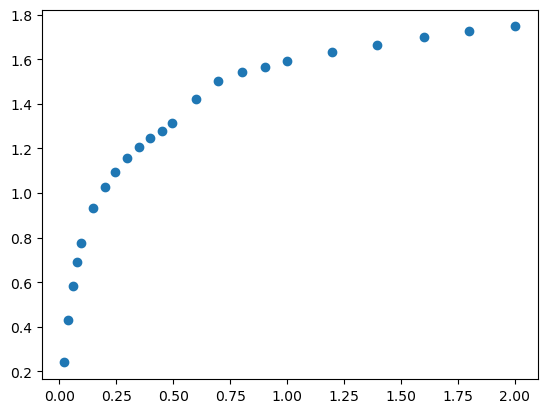

In [4]:
Transfer_unit = 2.7719416667/5.6100437023 



pressure_list = [
            0.021648873072361,
            0.038256227758007,
            0.059015421115065,
            0.077698695136418,
            0.09638196915777,
            0.14827995255042,
            0.20017793594306,
            0.24584816132859,
            0.29774614472123,
            0.34756820877817,
            0.39739027283511,
            0.44928825622776,
            0.49495848161329,
            0.60083036773428,
            0.69839857651246,
            0.80219454329775,
            0.90183867141163,
            0.99733096085409,
            1.1986951364176,
            1.3959074733096,
            1.5993475682088,
            1.7986358244365,
            2.0020759193357
        ]

arr_3 = np.loadtxt("/home/yutao/dataset/exp_303.txt", delimiter=',')
plt.scatter(arr_3[:,0], Transfer_unit*arr_3[:,1], label = r"303K experiments")

picked_ls = [0, 3, 6, 9]#[0, 3, 6, 9, 12, 15, 18]
picked_pressure = [pressure_list[i] for i in picked_ls]
picked_isotherm = [arr_3[i,1]*Transfer_unit for i in picked_ls]

def is_close_to_list(value, value_list):
    for list_value in value_list:
        relative_error = abs((value - list_value) / list_value)
        if relative_error < 0.01:
            return 1
    return 0

In [5]:
import os
import numpy as np
from utils import scaling_gas, extract_from_raspa, write_scaling_gas
bar = 10**5
def move_traj(dest_path = "/home/yutao/project/MIL-120/traj0/",picked_pressure=picked_pressure):
    traj_ls = os.listdir(dest_path)
    isotherm_data = [[],[]] # the first list is for pressure, the second is for loading
    jdx = 0 
    for traj in extract_from_raspa(traj_ls):
        pdb_file = traj[1]
        if not pdb_file.endswith(".pdb") or 'Movie_framework' not in pdb_file:
            continue
        if not is_close_to_list(float(traj[0])/bar, picked_pressure):
            continue
        isotherm_data[0].append(float(traj[0])/bar)
        pdb_path = os.path.join(dest_path, pdb_file)
        with open(pdb_path) as f:
            lines = f.readlines()
        num_atoms_list = []  # List to store the number of atoms in each structure
        index = 0
        write_idx = 1
        num_atoms = 0  # Variable to store the number of atoms in the current structure
        directory = f"./traj/{jdx+1}"
        jdx += 1
        if not os.path.exists(directory):
            os.makedirs(directory)
            print("Directory created:", directory)
        for line in lines:
            if line.startswith("MODEL"):
                if index>=150:
                    write_scaling_gas(block_coords, "data/gas.pdb", write_idx, dest_path=directory)
                    write_idx += 1
                block_coords = []
                block_Csym = []
                index += 1
                num_atoms_list.append(num_atoms)  # Add the number of atoms to the list
                num_atoms = 0  # Reset the number of atoms for the next structure
            if line.startswith("ATOM"):
                parts = line.split()
                coords = np.array([float(parts[4]), float(parts[5]), float(parts[6])])
                block_coords.append(coords)
                block_Csym.append(parts[-1])
                num_atoms += 1  # Increment the number of atoms
        #num_atoms_list.append(num_atoms)  # Add the number of atoms for the last structure
        isotherm_data[1].append(sum(num_atoms_list)/len(num_atoms_list)/3/3/2/3)
        #print("Number of atoms in each structure for", pdb_file, ":", num_atoms_list)
    return isotherm_data

Some self-defined functions:

In [6]:
def update_mask(parameters, mask):
    updated_parameters = parameters.copy()
    
    for force_type, force_params in mask.items():
        if force_type in parameters:
            for param, mask_array in force_params.items():
                if param in parameters[force_type]:
                    # Update values based on the mask
                    updated_parameters[force_type][param] = jnp.where(mask_array == 1, 
                                                                      parameters[force_type][param], 
                                                                      0)
    return updated_parameters

In [7]:
def compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=cutoff):
    topodata = dmff.DMFFTopology(topo)
    # Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
    for atom in topodata.atoms():
        if atom.residue.name=="MOL":
            atom.meta['type']=atom.meta['element']
            atom.meta['class']=atom.meta['element']
        elif atom.residue.name=="GAS":
            #print(atom.meta)
            atom.meta['type']=atom.meta['element']+"_co2"
            atom.meta['class']=atom.meta['element']+"_co2"
        #print(atom.meta['element'])
    cov_mat = topodata.buildCovMat()
    lj_force = lj_gen.createPotential(
    topodata, nonbondedMethod=app.PME, nonbondedCutoff=cutoff, args={})
    pos_jnp = jnp.array(pos.value_in_unit(unit.nanometer))
    cell_jnp = jnp.array(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer))
    cov_mat=cov_mat.at[:numframe,:numframe].set(1)
    nblist = NeighborListFreud(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
    nblist.allocate(pos_jnp, cell_jnp)
    pairs = jnp.array(nblist.pairs)
    ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)
    return ener

In [8]:
def analyse_traj(paramset, lj_gen, dest_path = "./traj/", interval=10):
    traj_dict = {}
    global Number_points, Trajectory_length, cutoff
    traj_ls = os.listdir(dest_path)
    create_supercell("data/MIL-120.pdb", scaling_factors, "scaled_frame.pdb")

    # Filter out file names and keep only directory names
    dir_names = [name for name in traj_ls if os.path.isdir(os.path.join(dest_path, name)) and name.isdigit()]
    dir_names = sorted(map(int, dir_names))
    dir_names = [str(i) for i in dir_names]
    for directory in dir_names[:Number_points]:
        idx = int(directory)
        traj_dict[idx] = {'experiment': {'pressure': picked_pressure[idx-1], 'loading': picked_isotherm[idx-1]}, 'structure': [], 'refer_energy':[], 'loading':[]}
        gas_dir = os.path.join(dest_path, directory)
        for gas_path in os.listdir(gas_dir)[::interval]:
            topo, pos, num = simple_merge("scaled_frame.pdb",os.path.join(gas_dir,gas_path))
            ener_lj = compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=cutoff)
            traj_dict[idx]['structure'].append([topo, pos])
            traj_dict[idx]['loading'].append(num/scaling_factors[0]/scaling_factors[1]/scaling_factors[2]/3)
            traj_dict[idx]['refer_energy'].append(ener_lj)
    clear_backends()    
    for key in traj_dict.keys():
        traj_dict[key]['refer_energy'] = jnp.array(traj_dict[key]['refer_energy'])
        traj_dict[key]['loading'] = jnp.array(traj_dict[key]['loading'])
        traj_dict[key]['estimator'] = ReweightEstimator(ref_energies=traj_dict[key]['refer_energy'], temperature=SET_temperature)
    return traj_dict

In [5]:
display

<function IPython.core.display_functions.display(*objs, include=None, exclude=None, metadata=None, transient=None, display_id=None, raw=False, clear=False, **kwargs)>

In [4]:
import subprocess
def sample(cmd="/home/yutao/project/aiida/applications/sample.sh"):
    command = [cmd]
    # Run the script using subprocess
    completed_process = subprocess.run(command, capture_output=True, cwd="/home/yutao/project/aiida/applications",text=True)

    # Check the return code
    if completed_process.returncode == 0:
        # The script finished successfully
        print("Script finished successfully!")
        # Display the output in the notebook
        print("Script output:")
        print(completed_process.stdout)
        # Continue with your program logic here
    else:
        # The script encountered an error
        print("Script encountered an error:", completed_process.stderr)
        print("Script encountered an error:", completed_process.stderr)
        # Handle the error or exit the program

In [10]:
def detect_parameter_change(paramset_new, paramset_old):
    # Get the initial parameters
    initial_sigma = paramset_old.parameters['LennardJonesForce']['sigma']
    initial_epsilon = paramset_old.parameters['LennardJonesForce']['epsilon']
    
    # Get the updated parameters
    updated_sigma = paramset_new.parameters['LennardJonesForce']['sigma']
    updated_epsilon = paramset_new.parameters['LennardJonesForce']['epsilon']
    
    # Calculate the percentage change for each parameter
    sigma_change = np.abs(updated_sigma - initial_sigma) / initial_sigma
    epsilon_change = np.abs(updated_epsilon - initial_epsilon) / initial_epsilon

    # Find the indices of values that have changed by more than 40%
    sigma_indices = np.where(sigma_change > 0.4)[0]
    epsilon_indices = np.where(epsilon_change > 0.4)[0]
    
    return sigma_indices, epsilon_indices

def fix_changed_parameters(paramset, sigma_indices, epsilon_indices):
    for idx in sigma_indices:
        paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[idx].set(0)
    for idx in epsilon_indices:
        paramset.mask['LennardJonesForce']['epsilon'] = paramset.mask['LennardJonesForce']['epsilon'].at[idx].set(0)
    return paramset

In [11]:
# Initial Optimized parameters
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
paramset_old = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset_old)
# Initial Optimized model
'''
import optax
optimizer = optax.adam(0.005)
opt_state = optimizer.init(paramset)
'''

'\nimport optax\noptimizer = optax.adam(0.005)\nopt_state = optimizer.init(paramset)\n'

In [2]:
import json
Transfer_energy_unit = 254.152/2.11525
Transfer_length_unit = 10
def update_ff(paramset, dest_path='/home/yutao/project/aiida/applications/ff_1.json'):
    global Transfer_energy_unit, Transfer_length_unit
    element_list = ['Al_', 'C_', 'H_', 'O_']
    params = paramset.parameters
    ff_data = {}
    if len(element_list) != params['LennardJonesForce']['sigma'].shape[0]-2:
        raise ValueError("Length of element list and parameter list does not match")
    sigma_list = params['LennardJonesForce']['sigma'].tolist()
    epsilon_list = params['LennardJonesForce']['epsilon'].tolist()
    for idx in range(len(element_list)):
        ff_data[element_list[idx]] = ['lennard-jones', epsilon_list[idx]*Transfer_energy_unit, sigma_list[idx]*Transfer_length_unit]
    with open(dest_path, 'w') as f:
        json.dump(ff_data, f, indent=4)

def show_ff(file_path='/home/yutao/project/aiida/applications/ff_1.json'):
    global Transfer_energy_unit, Transfer_length_unit
    element_list = ['Al_', 'C_', 'H_', 'O_']
    ff_data = json.load(open(file_path))

    for idx in range(len(element_list)):
        print(ff_data[element_list[idx]][0],ff_data[element_list[idx]][1]/Transfer_energy_unit,ff_data[element_list[idx]][2]/Transfer_length_unit)
#update_ff(paramset)

In [1]:
ls = [1.35872833, 0.13045846, 0.0476926,  0.07261055, 0.65757,    0.22469]
Transfer_energy_unit = 254.152/2.11525
for i in ls:
    print(Transfer_energy_unit*i)

163.2542359182886
15.67487461336485
5.730372142867273
8.724319349296772
79.0085004798487
26.99700407989599


In [4]:
ls =  [1.37766234,0.12262232,0.04404346,0.07276454,0.65757,0.22469]
Transfer_energy_unit = 254.152/2.11525
for i in ls:
    print(Transfer_energy_unit*i)

165.5291994022834
14.733344934471102
5.291919842061222
8.742821590866328
79.0085004798487
26.99700407989599


In [ ]:
 [1.37766234 0.12262232 0.04404346 0.07276454 0.65757    0.22469   ]

In [ ]:
{
    "Al_": [
        "lennard-jones",
        165.5291994022834,
        4.0082
    ],
    "C_": [
        "lennard-jones",
        14.733344934471102,
        3.4309000000000003
    ],
    "H_": [
        "lennard-jones",
        5.291919842061222,
        2.5711
    ],
    "O_": [
        "lennard-jones",
        8.742821590866328,
        3.1180999999999996
    ]
}


In [14]:
show_ff('/home/yutao/project/aiida/applications/ff_1.json')

lennard-jones 1.7929603943128674 0.40082000000000007
lennard-jones 0.2566655360373521 0.34309
lennard-jones 0.1074632711055779 0.25711
lennard-jones 0.1448795107317152 0.31181


In [3]:
show_ff('/home/yutao/project/aiida/applications/ff_1.json')

lennard-jones 1.7929603943128674 0.40082000000000007
lennard-jones 0.2566655360373521 0.34309
lennard-jones 0.1074632711055779 0.25711
lennard-jones 0.1448795107317152 0.31181


One example: I fit three points and control the change of parameters

In [15]:
from jax._src.api import clear_backends

In [14]:
for nloop in range(10):

    if nloop % 5 == 0:
        clear_backends()
    #sample()
    move_traj()
    traj_dict = analyse_traj(paramset, lj_gen)

    def loss(paramset):
        errors = []
        for idx in [6]:#range(1, Number_points+1):
            energies = []
            for jdx in range(int(Trajectory_length/10)):
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)

    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    
    paramset_old = paramset
    lj_gen_old = lj_gen
    
    updates, opt_state = optimizer.update(g, opt_state)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    update_ff(paramset)
    lj_gen.overwrite(paramset)
    

KeyboardInterrupt: 

In [11]:
paramset_old = paramset
lj_gen_old = lj_gen
for nloop in range(10):

    if nloop % 5 == 0:
        clear_backends()
    sample()
    move_traj()
    traj_dict = analyse_traj(paramset_old, lj_gen_old)

    def loss(paramset):
        errors = []
        for idx in [6]:#range(1, Number_points+1):
            energies = []
            for jdx in range(int(Trajectory_length/10)):
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)

    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    
    paramset_old = paramset
    lj_gen_old = lj_gen
    
    updates, opt_state = optimizer.update(g, opt_state)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    update_ff(paramset)
    lj_gen.overwrite(paramset)

'Script finished successfully!'

'Script output:'

'This is the final pk values:  252510\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  252587\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  252639\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  252691\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  252758\n'

KeyboardInterrupt: 

In [15]:
# Initial Optimized parameters
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)

xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset_old = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset_old)

paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[0].set(0)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[1].set(0)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[2].set(0)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[3].set(0)




In [18]:
# Initial Optimized parameters
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset_old = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset_old)

xmlio = XMLIO()
xmlio.loadXML("data/transition.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)


paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[0].set(0)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[1].set(0)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[2].set(0)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[3].set(0)

In [17]:
xmlio.loadXML("data/init.xml")
ffinfo_old = xmlio.parseXML()
paramset_old = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo_old, paramset_old)

In [57]:
ffinfo_old["Forces"]

{'LennardJonesForce': {'meta': {'lj14scale': '1.0'},
  'node': [{'name': 'Atom',
    'attrib': {'epsilon': '1.8905569548195686',
     'sigma': '0.40082',
     'type': 'Al',
     'mask': 'false'}},
   {'name': 'Atom',
    'attrib': {'epsilon': '0.2616655360346563',
     'sigma': '0.34309',
     'type': 'C',
     'mask': 'false'}},
   {'name': 'Atom',
    'attrib': {'epsilon': '0.17446061282870007',
     'sigma': '0.25711',
     'type': 'H',
     'mask': 'false'}},
   {'name': 'Atom',
    'attrib': {'epsilon': '0.149879510726876',
     'sigma': '0.31181',
     'type': 'O',
     'mask': 'false'}},
   {'name': 'Atom',
    'attrib': {'epsilon': '0.65757',
     'sigma': '0.305',
     'type': 'O_co2',
     'mask': 'true'}},
   {'name': 'Atom',
    'attrib': {'epsilon': '0.22469',
     'sigma': '0.28',
     'type': 'C_co2',
     'mask': 'true'}},
   {'name': 'Atom',
    'attrib': {'epsilon': '2.11525',
     'sigma': '0.40082',
     'type': 'Al',
     'mask': 'false'}},
   {'name': 'Atom',
    

In [58]:
for node in ffinfo_old["Forces"]['LennardJonesForce']["node"]:
    if node["name"] == "Atom":
        if "type" in node["attrib"]:
            atype, eps, sig = node["attrib"]["type"], node["attrib"][
                "epsilon"], node["attrib"]["sigma"]
        elif "class" in node["attrib"]:
            acls, eps, sig = node["attrib"]["class"], node["attrib"][
                "epsilon"], node["attrib"]["sigma"]
            atypes = ffinfo["ClassToType"][acls]
        print(node)

{'name': 'Atom', 'attrib': {'epsilon': '1.8905569548195686', 'sigma': '0.40082', 'type': 'Al', 'mask': 'false'}}
{'name': 'Atom', 'attrib': {'epsilon': '0.2616655360346563', 'sigma': '0.34309', 'type': 'C', 'mask': 'false'}}
{'name': 'Atom', 'attrib': {'epsilon': '0.17446061282870007', 'sigma': '0.25711', 'type': 'H', 'mask': 'false'}}
{'name': 'Atom', 'attrib': {'epsilon': '0.149879510726876', 'sigma': '0.31181', 'type': 'O', 'mask': 'false'}}
{'name': 'Atom', 'attrib': {'epsilon': '0.65757', 'sigma': '0.305', 'type': 'O_co2', 'mask': 'true'}}
{'name': 'Atom', 'attrib': {'epsilon': '0.22469', 'sigma': '0.28', 'type': 'C_co2', 'mask': 'true'}}
{'name': 'Atom', 'attrib': {'epsilon': '2.11525', 'sigma': '0.40082', 'type': 'Al', 'mask': 'false'}}
{'name': 'Atom', 'attrib': {'epsilon': '0.43979', 'sigma': '0.34309', 'type': 'C', 'mask': 'false'}}
{'name': 'Atom', 'attrib': {'epsilon': '0.18436', 'sigma': '0.25711', 'type': 'H', 'mask': 'false'}}
{'name': 'Atom', 'attrib': {'epsilon': '0.25

In [50]:
ffinfo_old

{'Operators': {},
 'AtomTypes': [],
 'Residues': [],
 'Forces': {'LennardJonesForce': {'meta': {'lj14scale': '1.0'},
   'node': [{'name': 'Atom',
     'attrib': {'epsilon': '1.8905569548195686',
      'sigma': '0.40082',
      'type': 'Al',
      'mask': 'false'}},
    {'name': 'Atom',
     'attrib': {'epsilon': '0.2616655360346563',
      'sigma': '0.34309',
      'type': 'C',
      'mask': 'false'}},
    {'name': 'Atom',
     'attrib': {'epsilon': '0.17446061282870007',
      'sigma': '0.25711',
      'type': 'H',
      'mask': 'false'}},
    {'name': 'Atom',
     'attrib': {'epsilon': '0.149879510726876',
      'sigma': '0.31181',
      'type': 'O',
      'mask': 'false'}},
    {'name': 'Atom',
     'attrib': {'epsilon': '0.65757',
      'sigma': '0.305',
      'type': 'O_co2',
      'mask': 'true'}},
    {'name': 'Atom',
     'attrib': {'epsilon': '0.22469',
      'sigma': '0.28',
      'type': 'C_co2',
      'mask': 'true'}},
    {'name': 'Atom',
     'attrib': {'epsilon': '2.1152

In [46]:
paramset_old = ParamSet()

In [61]:
paramset_old.parameters

{'LennardJonesForce': {'sigma': Array([0.40082, 0.34309, 0.25711, 0.31181, 0.305  , 0.28   ], dtype=float64),
  'epsilon': Array([2.11525, 0.43979, 0.18436, 0.25079, 0.65757, 0.22469], dtype=float64),
  'sigma_nbfix': Array([], dtype=float64),
  'epsilon_nbfix': Array([], dtype=float64)}}

In [19]:
# Initial Optimized model
import optax
optimizer = optax.adam(0.005)
opt_state = optimizer.init(paramset)

In [14]:
#sample()
#move_traj()
traj_dict = analyse_traj(paramset, lj_gen)

def loss(paramset):
    errors = []
    for idx in range(1, Number_points+1):
        energies = []
        for jdx in range(len(traj_dict[idx]['structure'])):  
            ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
            energies.append(ener.reshape((1,)))
        energies = jnp.concatenate(energies)
        weight = traj_dict[idx]['estimator'].estimate_weight(energies)
        reweight_loading = traj_dict[idx]['loading'] * weight
        error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
        errors.append(error.reshape((1,)))
        #print(error)
    errors = jnp.concatenate(errors)
    return jnp.sum(errors)

v_and_g = jax.value_and_grad(loss, 0)
v, g = v_and_g(paramset)
#loss_ls.append(v)

updates, opt_state = optimizer.update(g, opt_state)
updates.parameters = update_mask(updates.parameters,paramset.mask)
paramset = optax.apply_updates(paramset, updates)
paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
update_ff(paramset)
lj_gen.overwrite(paramset)
sigma_indices, epsilon_indices = detect_parameter_change(paramset, paramset_old)
paramset = fix_changed_parameters(paramset, sigma_indices, epsilon_indices)
print(f"This is {nloop}th time", f" Loss: {v} and Parameters: ",paramset.parameters['LennardJonesForce']['sigma'], paramset.parameters['LennardJonesForce']['epsilon'])

NameError: name 'optimizer' is not defined

In [16]:
updates, opt_state = optimizer.update(g, opt_state)
updates.parameters = update_mask(updates.parameters,paramset.mask)
paramset = optax.apply_updates(paramset, updates)
paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
update_ff(paramset)
lj_gen.overwrite(paramset)
sigma_indices, epsilon_indices = detect_parameter_change(paramset, paramset_old)
paramset = fix_changed_parameters(paramset, sigma_indices, epsilon_indices)
#print(f"This is {nloop}th time", f" Loss: {v} and Parameters: ",paramset.parameters['LennardJonesForce']['sigma'], paramset.parameters['LennardJonesForce']['epsilon'])

NameError: name 'nloop' is not defined

In [17]:
sigma_indices, epsilon_indices = detect_parameter_change(paramset, paramset_old)
paramset = fix_changed_parameters(paramset, sigma_indices, epsilon_indices)
#print(f"This is {nloop}th time", f" Loss: {v} and Parameters: ",paramset.parameters['LennardJonesForce']['sigma'], paramset.parameters['LennardJonesForce']['epsilon'])

In [17]:
paramset.parameters['LennardJonesForce']['sigma']

Array([0.40082, 0.34309, 0.25711, 0.31181, 0.305  , 0.28   ], dtype=float64)

In [17]:

loss_ls = []
#os.system("cp /home/yutao/project/aiida/applications/UFF.json /home/yutao/project/aiida/applications/ff_1.json")

for nloop in range(80):

    sample()
    move_traj()
    traj_dict = analyse_traj(paramset, lj_gen)

    def loss(paramset):
        errors = []
        for idx in range(1, Number_points+1):
            energies = []
            for jdx in range(len(traj_dict[idx]['structure'])):  
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)

    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    loss_ls.append(v)
    
    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    update_ff(paramset)
    lj_gen.overwrite(paramset)
    sigma_indices, epsilon_indices = detect_parameter_change(paramset, paramset_old)
    paramset = fix_changed_parameters(paramset, sigma_indices, epsilon_indices)
    print("Successfully update once")
    print(f"This is {nloop}th time", f" Loss: {v} and Parameters: ",paramset.parameters['LennardJonesForce']['sigma'], paramset.parameters['LennardJonesForce']['epsilon'])
    clear_backends()
    clear_caches()

'Script finished successfully!'

'Script output:'

'This is the final pk values:  261685\n'

Successfully update once
This is 0th time  Loss: 4.765326610580542 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.88555695 0.25666554 0.16946061 0.14487951 0.65757    0.22469   ]


'Script finished successfully!'

'Script output:'

'This is the final pk values:  261807\n'

Successfully update once
This is 1th time  Loss: 4.798427087062577 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.88059765 0.25666554 0.16445949 0.14487951 0.65757    0.22469   ]


'Script finished successfully!'

'Script output:'

'This is the final pk values:  261956\n'

Successfully update once
This is 2th time  Loss: 4.4773644882226264 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.87561224 0.25666554 0.15969179 0.14487951 0.65757    0.22469   ]


'Script finished successfully!'

'Script output:'

'This is the final pk values:  262063\n'

Successfully update once
This is 3th time  Loss: 4.697900349379563 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.87060465 0.25666554 0.15498187 0.14487951 0.65757    0.22469   ]


'Script finished successfully!'

'Script output:'

'This is the final pk values:  262202\n'

Successfully update once
This is 4th time  Loss: 4.833595395037751 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.8657748  0.25666554 0.15067368 0.14487951 0.65757    0.22469   ]


'Script finished successfully!'

'Script output:'

'This is the final pk values:  262314\n'

Successfully update once
This is 5th time  Loss: 4.774350263895097 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.86086653 0.25666554 0.14614143 0.14487951 0.65757    0.22469   ]


'Script finished successfully!'

'Script output:'

'This is the final pk values:  262448\n'

Successfully update once
This is 6th time  Loss: 4.581418391023963 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.85600955 0.25666554 0.14164075 0.14487951 0.65757    0.22469   ]


'Script finished successfully!'

'Script output:'

'This is the final pk values:  262560\n'

Successfully update once
This is 7th time  Loss: 4.811464641893167 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.85114703 0.25666554 0.13711442 0.14487951 0.65757    0.22469   ]


'Script finished successfully!'

'Script output:'

'This is the final pk values:  262694\n'

Successfully update once
This is 8th time  Loss: 4.775829129651095 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.84624638 0.25666554 0.13248452 0.14487951 0.65757    0.22469   ]


'Script finished successfully!'

'Script output:'

'This is the final pk values:  262806\n'

Successfully update once
This is 9th time  Loss: 4.346088544907435 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.84125415 0.25666554 0.12785496 0.14487951 0.65757    0.22469   ]


'Script finished successfully!'

'Script output:'

'This is the final pk values:  262903\n'

Successfully update once
This is 10th time  Loss: 4.453042808121277 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.83640139 0.25666554 0.12334186 0.14487951 0.65757    0.22469   ]


'Script finished successfully!'

'Script output:'

'This is the final pk values:  263052\n'

Successfully update once
This is 11th time  Loss: 4.499960152772045 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.83157887 0.25666554 0.11945203 0.14487951 0.65757    0.22469   ]


'Script finished successfully!'

'Script output:'

'This is the final pk values:  263154\n'

Successfully update once
This is 12th time  Loss: 4.362013391974314 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.82678427 0.25666554 0.11562754 0.14487951 0.65757    0.22469   ]


'Script finished successfully!'

'Script output:'

'This is the final pk values:  263298\n'

Successfully update once
This is 13th time  Loss: 4.5749209674243145 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.82202554 0.25666554 0.11160381 0.14487951 0.65757    0.22469   ]


'Script finished successfully!'

'Script output:'

'This is the final pk values:  263400\n'

Successfully update once
This is 14th time  Loss: 4.385448464029292 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.81726295 0.25666554 0.10746327 0.14487951 0.65757    0.22469   ]


'Script finished successfully!'

'Script output:'

'This is the final pk values:  263544\n'

Successfully update once
This is 15th time  Loss: 4.3475561063722745 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.81245287 0.25666554 0.10746327 0.14487951 0.65757    0.22469   ]


'Script finished successfully!'

'Script output:'

'This is the final pk values:  263656\n'

Successfully update once
This is 16th time  Loss: 4.498150385713447 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.80759497 0.25666554 0.10746327 0.14487951 0.65757    0.22469   ]


'Script finished successfully!'

'Script output:'

'This is the final pk values:  263790\n'

Successfully update once
This is 17th time  Loss: 4.412065003063876 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.80270938 0.25666554 0.10746327 0.14487951 0.65757    0.22469   ]


'Script finished successfully!'

'Script output:'

'This is the final pk values:  263902\n'

Successfully update once
This is 18th time  Loss: 4.480237078735362 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.79784564 0.25666554 0.10746327 0.14487951 0.65757    0.22469   ]


'Script finished successfully!'

'Script output:'

'This is the final pk values:  264015\n'

Successfully update once
This is 19th time  Loss: 4.323688921494009 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.79296039 0.25666554 0.10746327 0.14487951 0.65757    0.22469   ]


KeyboardInterrupt: 

In [20]:
paramset.mask['LennardJonesForce']['epsilon'] = paramset.mask['LennardJonesForce']['epsilon'].at[0].set(0)
paramset.mask['LennardJonesForce']['epsilon'] = paramset.mask['LennardJonesForce']['epsilon'].at[1].set(0)
paramset.mask['LennardJonesForce']['epsilon'] = paramset.mask['LennardJonesForce']['epsilon'].at[2].set(0)
paramset.mask['LennardJonesForce']['epsilon'] = paramset.mask['LennardJonesForce']['epsilon'].at[3].set(0)

In [20]:
def detect_parameter_change(paramset_new, paramset_old):
    # Get the initial parameters
    initial_sigma = paramset_old.parameters['LennardJonesForce']['sigma']
    initial_epsilon = paramset_old.parameters['LennardJonesForce']['epsilon']
    
    # Get the updated parameters
    updated_sigma = paramset_new.parameters['LennardJonesForce']['sigma']
    updated_epsilon = paramset_new.parameters['LennardJonesForce']['epsilon']
    
    # Calculate the percentage change for each parameter
    sigma_change = np.abs(updated_sigma - initial_sigma) / initial_sigma
    epsilon_change = np.abs(updated_epsilon - initial_epsilon) / initial_epsilon

    # Find the indices of values that have changed by more than 40%
    sigma_indices = np.where(sigma_change > 0.7)[0]
    epsilon_indices = np.where(epsilon_change > 0.7)[0]
    
    return sigma_indices, epsilon_indices

def fix_changed_parameters(paramset, sigma_indices, epsilon_indices):
    for idx in sigma_indices:
        paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[idx].set(0)
    for idx in epsilon_indices:
        paramset.mask['LennardJonesForce']['epsilon'] = paramset.mask['LennardJonesForce']['epsilon'].at[idx].set(0)
    return paramset

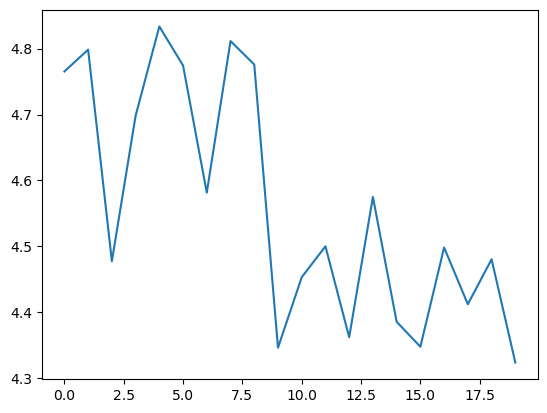

In [22]:
plt.plot(loss_ls)

In [21]:

loss_ls = []
#os.system("cp /home/yutao/project/aiida/applications/UFF.json /home/yutao/project/aiida/applications/ff_1.json")

for nloop in range(80):

    sample()
    move_traj()
    traj_dict = analyse_traj(paramset, lj_gen)

    def loss(paramset):
        errors = []
        for idx in range(1, Number_points+1):
            energies = []
            for jdx in range(len(traj_dict[idx]['structure'])):  
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)

    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    loss_ls.append(v)
    
    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    update_ff(paramset)
    lj_gen.overwrite(paramset)
    sigma_indices, epsilon_indices = detect_parameter_change(paramset, paramset_old)
    paramset = fix_changed_parameters(paramset, sigma_indices, epsilon_indices)
    print("Successfully update once")
    print(f"This is {nloop}th time", f" Loss: {v} and Parameters: ",paramset.parameters['LennardJonesForce']['sigma'], paramset.parameters['LennardJonesForce']['epsilon'])
    clear_backends()
    clear_caches()

'Script finished successfully!'

'Script output:'

'This is the final pk values:  264328\n'

In [18]:
paramset.mask

{'LennardJonesForce': {'sigma': Array([0., 0., 0., 0., 0., 0.], dtype=float64),
  'epsilon': Array([1., 0., 0., 0., 0., 0.], dtype=float64),
  'sigma_nbfix': Array([], dtype=float64),
  'epsilon_nbfix': Array([], dtype=float64)}}

In [18]:

loss_ls = []
#os.system("cp /home/yutao/project/aiida/applications/UFF.json /home/yutao/project/aiida/applications/ff_1.json")

for nloop in range(40):
    try:
        sample()
        move_traj()
        traj_dict = analyse_traj(paramset, lj_gen)

        def loss(paramset):
            errors = []
            for idx in range(1, Number_points+1):
                energies = []
                for jdx in range(len(traj_dict[idx]['structure'])):  
                    ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                    energies.append(ener.reshape((1,)))
                energies = jnp.concatenate(energies)
                weight = traj_dict[idx]['estimator'].estimate_weight(energies)
                reweight_loading = traj_dict[idx]['loading'] * weight
                error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
                errors.append(error.reshape((1,)))
                #print(error)
            errors = jnp.concatenate(errors)
            return jnp.sum(errors)

        v_and_g = jax.value_and_grad(loss, 0)
        v, g = v_and_g(paramset)
        loss_ls.append(v)
        
        updates, opt_state = optimizer.update(g, opt_state)
        updates.parameters = update_mask(updates.parameters,paramset.mask)
        paramset = optax.apply_updates(paramset, updates)
        paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
        update_ff(paramset)
        lj_gen.overwrite(paramset)
        sigma_indices, epsilon_indices = detect_parameter_change(paramset, paramset_old)
        paramset = fix_changed_parameters(paramset, sigma_indices, epsilon_indices)
        print("Successfully update once")
        print(f"This is {nloop}th time", f" Loss: {v} and Parameters: ",paramset.parameters['LennardJonesForce']['sigma'], paramset.parameters['LennardJonesForce']['epsilon'])
    except:
        print("Out of memory")
        clear_backends()
        clear_caches()

Out of memory


In [38]:
optimizer = optax.adam(0.01)
opt_state = optimizer.init(paramset)

In [39]:
optimizer.update(g, opt_state)

(<dmff.api.paramset.ParamSet at 0x7f66315ef850>,
 (ScaleByAdamState(count=Array(1, dtype=int32), mu=<dmff.api.paramset.ParamSet object at 0x7f6635e48bd0>, nu=<dmff.api.paramset.ParamSet object at 0x7f663002d610>),
  EmptyState()))

In [27]:
clear_backends()

In [29]:
for nloop in range(5, 80):
    clear_backends()    
    if nloop >=5:
        sample()
    move_traj()
    traj_dict = analyse_traj(paramset, lj_gen)

    def loss(paramset):
        errors = []
        for idx in range(1, Number_points+1):
            energies = []
            for jdx in range(len(traj_dict[idx]['structure'])):  
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)

    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    loss_ls.append(v)

    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    update_ff(paramset)
    lj_gen.overwrite(paramset)
    sigma_indices, epsilon_indices = detect_parameter_change(paramset, paramset_old)
    paramset = fix_changed_parameters(paramset, sigma_indices, epsilon_indices)

'Script finished successfully!'

'Script output:'

'This is the final pk values:  256979\n'

Script encountered an error: 01/29/2024 07:10:00 PM <1199499> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [257051|IsothermWorkChain|run_zeopp]: Running zeo++ block and volpo for CO2 Calculation<257060>
01/29/2024 07:12:03 PM <1199499> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [257051|IsothermWorkChain|should_run_widom]: Found accessible pore volume for CO2: continue
01/29/2024 07:12:04 PM <1199499> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [257051|IsothermWorkChain|should_run_widom]: Found 0 blocking spheres
01/29/2024 07:12:05 PM <1199499> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [257051|IsothermWorkChain|run_raspa_widom]: Running Raspa Widom CO2 @ 303K for the Henry coefficient
01/29/2024 07:12:05 PM <1199499> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [257075|RaspaBaseWorkChain|run_process]: launching RaspaCalculation<257079> iteration #1
01/29/2024 07:14:09 PM 

'Script encountered an error:'

'01/29/2024 07:10:00 PM <1199499> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [257051|IsothermWorkChain|run_zeopp]: Running zeo++ block and volpo for CO2 Calculation<257060>\n01/29/2024 07:12:03 PM <1199499> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [257051|IsothermWorkChain|should_run_widom]: Found accessible pore volume for CO2: continue\n01/29/2024 07:12:04 PM <1199499> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [257051|IsothermWorkChain|should_run_widom]: Found 0 blocking spheres\n01/29/2024 07:12:05 PM <1199499> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [257051|IsothermWorkChain|run_raspa_widom]: Running Raspa Widom CO2 @ 303K for the Henry coefficient\n01/29/2024 07:12:05 PM <1199499> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [257075|RaspaBaseWorkChain|run_process]: launching RaspaCalculation<257079> iteration #1\n01/29/2024 07:14:09 PM <1199499> aiida.orm.nod

'Script finished successfully!'

'Script output:'

'This is the final pk values:  257123\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  257195\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  257267\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  257339\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  257411\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  257483\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  257555\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  257627\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  257699\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  257771\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  257843\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  257915\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  257987\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  258059\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  258131\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  258203\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  258275\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  258347\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  258419\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  258491\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  258563\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  258635\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  258707\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  258779\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  258851\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  258923\n'

KeyboardInterrupt: 

In [3]:
v_and_g._cache_size()

NameError: name 'v_and_g' is not defined

In [59]:
!pip install pytest

DEPRECATION: Loading egg at /home/yutao/anaconda3/envs/dmff/lib/python3.11/site-packages/grand-1.1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached iniconfig-2.0.0-py3-none-any.whl (5.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.0/334.0 kB 7.2 MB/s eta 0:00:00:00:01


In [61]:
pytest

<module 'pytest' from '/home/yutao/anaconda3/envs/dmff/lib/python3.11/site-packages/pytest/__init__.py'>

In [60]:
import pytest, psutil, gc
@pytest.fixture(autouse=True)
def clear_caches():
    process = psutil.Process()
    if process.memory_info().vms > 4 * 2**30:  # >4GB memory usage
        for module_name, module in sys.modules.items():
            if module_name.startswith("jax"):
                for obj_name in dir(module):
                    obj = getattr(module, obj_name)
                    if hasattr(obj, "cache_clear"):
                        obj.cache_clear()
        gc.collect()

# Call the clear_caches() function whenever you want to clear the caches
clear_caches()

Failed: Fixture "clear_caches" called directly. Fixtures are not meant to be called directly,
but are created automatically when test functions request them as parameters.
See https://docs.pytest.org/en/stable/explanation/fixtures.html for more information about fixtures, and
https://docs.pytest.org/en/stable/deprecations.html#calling-fixtures-directly about how to update your code.

In [62]:
from jax import clear_caches

In [63]:
clear_caches()

In [54]:
from jax import jit

@jit
def f(x):
  return x + 1

f.clear_cache()

In [55]:
v_and_g.clear_cache()

AttributeError: 'function' object has no attribute 'clear_cache'

In [52]:
from jax import jit

@jit
def f(x):
  return x + 1

print(f._cache_size())
# 0

f(1.0)
print(f._cache_size())
# 1

f(1)
print(f._cache_size())
# 2

f._clear_cache()
print(f._cache_size())
# 0

0


JIT session error: Cannot allocate memory


XlaRuntimeError: INVALID_ARGUMENT: Symbol main.4 not found.

In [47]:
import jax

# Clear JAX XLA cache
jax.xla_computation.cache_clear()

AttributeError: 'function' object has no attribute 'cache_clear'

In [2]:
from jax import clear_caches, clear_backends

In [64]:
#clear_backends()
v_and_g = jax.value_and_grad(loss, 0)
v, g = v_and_g(paramset)

In [49]:
import jax

# Clear JAX XLA compilation cache
jax.lib.xla_compilation_cache_clear()

AttributeError: module 'jax.lib' has no attribute 'xla_compilation_cache_clear'

In [65]:
for nloop in range(35, 80):
    clear_caches()
    clear_backends()    
    if nloop % 2:
        sample()
    move_traj()
    traj_dict = analyse_traj(paramset, lj_gen)

    def loss(paramset):
        errors = []
        for idx in range(1, Number_points+1):
            energies = []
            for jdx in range(len(traj_dict[idx]['structure'])):  
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)

    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    loss_ls.append(v)

    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    update_ff(paramset)
    lj_gen.overwrite(paramset)
    sigma_indices, epsilon_indices = detect_parameter_change(paramset, paramset_old)
    paramset = fix_changed_parameters(paramset, sigma_indices, epsilon_indices)

'Script finished successfully!'

'Script output:'

'This is the final pk values:  259427\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  259576\n'

In [34]:
paramset.parameters['LennardJonesForce']['epsilon']

Array([1.95061239, 0.27166554, 0.23448218, 0.14987951, 0.65757   ,
       0.22469   ], dtype=float64)

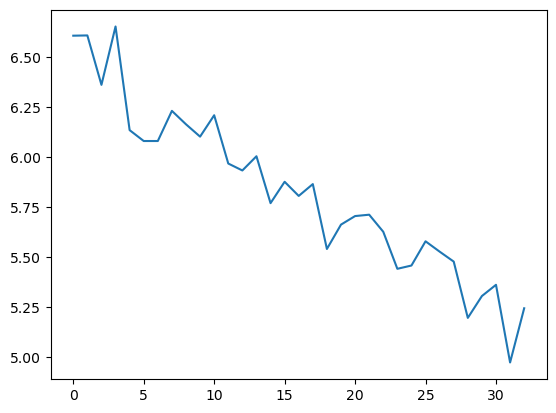

In [35]:
plt.plot(loss_ls)

In [33]:
paramset.mask

{'LennardJonesForce': {'sigma': Array([0., 0., 0., 0., 0., 0.], dtype=float64),
  'epsilon': Array([1., 1., 1., 0., 0., 0.], dtype=float64),
  'sigma_nbfix': Array([], dtype=float64),
  'epsilon_nbfix': Array([], dtype=float64)}}

In [25]:
v

Array(6.65456854, dtype=float64)

In [21]:
update_ff

<function __main__.update_ff(paramset, dest_path='/home/yutao/project/aiida/applications/ff_1.json')>

In [20]:
fix_changed_parameters

<function __main__.fix_changed_parameters(paramset_new, sigma_indices, epsilon_indices)>

In [72]:
def loss(paramset):
    errors = []
    for idx in range(1, Number_points+1):
        energies = []
        for jdx in range(len(traj_dict[idx]['structure'])):
            ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
            print(ener)
            energies.append(ener.reshape((1,)))
        energies = jnp.concatenate(energies)
        weight = traj_dict[idx]['estimator'].estimate_weight(energies)
        reweight_loading = traj_dict[idx]['loading'] * weight
        print(weight)
        print(traj_dict[idx]['experiment']['loading'])
        error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
        errors.append(error.reshape((1,)))
        #print(error)
    errors = jnp.concatenate(errors)
    return jnp.sum(errors)


In [70]:
traj_dict[1]['estimator']

In [73]:
loss(paramset)

-134.11803293879728
64.14777184630512
-109.52924623271738
-16.511723408748093
-95.05879251136503
-23.825326467410022
31.8318915067813
-52.562460192646164
-28.697603830357842
-88.95329513421895
-26.72122127604402
-163.69874901474705
-102.52884608246674
2.4255780298655765
-73.98301560601183
-52.491631438813535
25.780388773095048
-64.59964629247634
-69.09080401654649
-28.570069745055875
172.48198084235577
-36.03736692363901
203.69957936102674
24.028883484712416
-86.81482941181775
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
0.24030165348645946
-67.11139067533382
-39.10659445003077
-28.61076320015686
-283.5834651441683
-124.42757708692825
167.68732397435386
-17.84842883008333
-304.2968811441422
-192.1859401529032
76.83195537103975
-270.0099895900107
-169.96435004351895
16.22240389806003
-75.21521670578069
-275.91183825945313
37.6500256023655
-175.73463566569524
709.3116791473221
-70.72745173567893
-111.17174526954075
473.86575731877133
-213.80432873910627
-

Array(0.04240318, dtype=float64)

In [58]:
v

Array(nan, dtype=float64)

In [55]:
paramset.mask

{'LennardJonesForce': {'sigma': Array([0., 0., 0., 0., 0., 0.], dtype=float64),
  'epsilon': Array([1., 1., 1., 1., 0., 0.], dtype=float64),
  'sigma_nbfix': Array([], dtype=float64),
  'epsilon_nbfix': Array([], dtype=float64)}}

In [ ]:
plt.plot(loss_ls)


In [23]:
from matplotlib import pyplot as plt
plt.plot(loss_ls)

NameError: name 'loss_ls' is not defined

In [17]:
paramset_old = paramset
lj_gen_old = lj_gen
loss_ls = []
os.system("cp /home/yutao/project/aiida/applications/UFF.json /home/yutao/project/aiida/applications/ff_1.json")

for nloop in range(10):
    sample()
    move_traj()
    traj_dict = analyse_traj(paramset, lj_gen)

    def loss(paramset):
        errors = []
        for idx in [6]:#range(1, Number_points+1):
            energies = []
            for jdx in range(int(Trajectory_length/10)):
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)

    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    loss_ls.append(v)
    
    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    update_ff(paramset)
    lj_gen.overwrite(paramset)
    sigma_indices, epsilon_indices = detect_parameter_change(paramset, paramset_old)
    paramset = fix_changed_parameters(paramset, sigma_indices, epsilon_indices)

'Script finished successfully!'

'Script output:'

'This is the final pk values:  252982\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  253122\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  253204\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  253286\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  253368\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  253445\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  253502\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  253554\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  253606\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  253658\n'

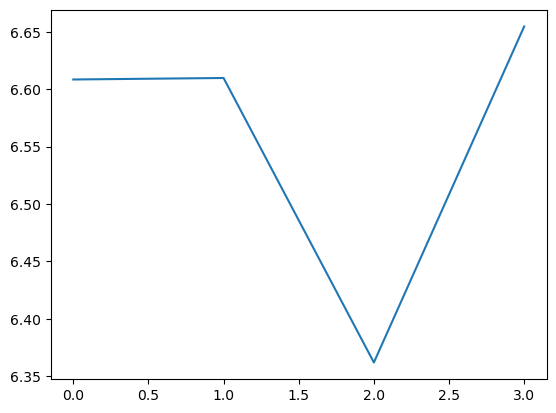

In [24]:
plt.plot(loss_ls)

In [19]:
for nloop in range(30):
    sample()
    move_traj()
    traj_dict = analyse_traj(paramset, lj_gen)

    def loss(paramset):
        errors = []
        for idx in [6]:#range(1, Number_points+1):
            energies = []
            for jdx in range(int(Trajectory_length/10)):
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)

    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    loss_ls.append(v)
    
    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    update_ff(paramset)
    lj_gen.overwrite(paramset)

'Script finished successfully!'

'Script output:'

'This is the final pk values:  253726\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  253861\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  253918\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  253970\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  254022\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  254074\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  254126\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  254178\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  254230\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  254282\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  254334\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  254386\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  254438\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  254490\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  254542\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  254594\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  254646\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  254698\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  254750\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  254802\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  254854\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  254906\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  254958\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  255010\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  255062\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  255114\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  255166\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  255218\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  255270\n'

'Script finished successfully!'

'Script output:'

'This is the final pk values:  255322\n'

In [20]:
print(v)

0.7674936853960864


In [ ]:
for nloop in range(20):
    sample()
    move_traj()
    traj_dict = analyse_traj(paramset, lj_gen)

    def loss(paramset):
        errors = []
        for idx in [6]:#range(1, Number_points+1):
            energies = []
            for jdx in range(int(Trajectory_length/10)):
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)

    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    
    
    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    update_ff(paramset)
    lj_gen.overwrite(paramset)

In [53]:
paramset.parameters

{'LennardJonesForce': {'epsilon': Array([2.07177802, 0.3934429 , 0.12235369, 0.20189922, 0.61298042,
         0.18180163], dtype=float64),
  'epsilon_nbfix': Array([], dtype=float64),
  'sigma': Array([0.35621847, 0.29001147, 0.27962272, 0.35027955, 0.34223068,
         0.24036733], dtype=float64),
  'sigma_nbfix': Array([], dtype=float64)}}

In [ ]:

def compute_energy(topo, pos, ff, cutoff=cutoff, removeLJ=False):
    global SET_temperature, time_gap
    system = ff.createSystem(topo, nonbondedMethod=app.PME, nonbondedCutoff=cutoff*unit.nanometer, constraints=None, removeCMMotion=False)
    for force in system.getForces():
        #print(force)
        if isinstance(force, mm.NonbondedForce):
            force.setUseDispersionCorrection(False)
            if removeLJ:
                for npart in range(force.getNumParticles()):
                    chrg, sig, eps = force.getParticleParameters(npart)
                    force.setParticleParameters(npart, chrg, 1.0, 0.0)
                for nex in range(force.getNumExceptions()):
                    p1, p2, chrg, sig, eps = force.getExceptionParameters(nex)
                    force.setExceptionParameters(nex, p1, p2, chrg, 1.0, 0.0)
                    #print(nex, p1, p2, chrg, 1.0, 0.0)
    integ = mm.LangevinIntegrator(SET_temperature*unit.kelvin, 1/unit.picosecond, time_gap*unit.femtosecond)
    simulation = app.Simulation(topo, system, integ)
    simulation.context.setPositions(pos)
    state=simulation.context.getState(getEnergy=True)
    potential_energy = state.getPotentialEnergy().in_units_of(unit.kilojoules_per_mole)
    return potential_energy.value_in_unit(unit.kilojoules_per_mole)
    
def binding_energy(topo, positions, ff, cutoff=cutoff, removeLJ=False):
    gas_topo, frame_topo = cutoff_topology(topo)
    num = gas_topo.getNumAtoms()
    total_ener = compute_energy(topo,positions,ff,cutoff=cutoff,removeLJ=removeLJ)
    #print(frame_topo, gas_topo,len(positions[:-3]))
    #print(frame_topo, gas_topo)
    frame_ener = compute_energy(frame_topo,positions[:-num],ff,cutoff=cutoff, removeLJ=removeLJ)
    gas_ener = compute_energy(gas_topo,positions[-num:],ff,cutoff=cutoff, removeLJ=removeLJ)
    #print(gas_ener)
    return total_ener-frame_ener-gas_ener


def energy_estimator(topo, positions, ff, cutoff=cutoff, removeLJ=False):
    gas_topo, frame_topo = cutoff_topology(topo)
    num = gas_topo.getNumAtoms()
    total_ener = compute_energy(topo,positions,ff,cutoff=cutoff,removeLJ=removeLJ)
    #print(frame_topo, gas_topo,len(positions[:-3]))
    #print(frame_topo, gas_topo)
    frame_ener = compute_energy(frame_topo,positions[:-num],ff,cutoff=cutoff, removeLJ=removeLJ)
    #gas_ener = compute_energy(gas_topo,positions[-num:],ff,cutoff=cutoff, removeLJ=removeLJ)
    #print(gas_ener)
    return total_ener-frame_ener

In [171]:
gas_topo, frame_topo = cutoff_topology(topo)

In [5]:

def compute_energy_dmff(paramset,topo, pos, lj_gen, cutoff=cutoff):
    topodata = dmff.DMFFTopology(topo)
    # Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
    for atom in topodata.atoms():
        if atom.residue.name=="MOL":
            atom.meta['type']=atom.meta['element']
            atom.meta['class']=atom.meta['element']
        elif atom.residue.name=="GAS":
            #print(atom.meta)
            atom.meta['type']=atom.meta['element']+"_co2"
            atom.meta['class']=atom.meta['element']+"_co2"
        #print(atom.meta['element'])
    cov_mat = topodata.buildCovMat()
    lj_force = lj_gen.createPotential(
    topodata, nonbondedMethod=app.CutoffPeriodic, nonbondedCutoff=cutoff, args={})
    pos_jnp = jnp.array(pos.value_in_unit(unit.nanometer))
    cell_jnp = jnp.array(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer))
    #cov_mat = jnp.array(np.zeros((1923,1923)))
    nblist = NeighborListFreud(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
    nblist.allocate(pos_jnp, cell_jnp)
    pairs = jnp.array(nblist.pairs)
    ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)
    return ener

def compute_binding_energy(paramset,topo, pos, lj_gen, numframe=1920,cutoff=cutoff):
    topodata = dmff.DMFFTopology(topo)
    # Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
    for atom in topodata.atoms():
        if atom.residue.name=="MOL":
            atom.meta['type']=atom.meta['element']
            atom.meta['class']=atom.meta['element']
        elif atom.residue.name=="GAS":
            #print(atom.meta)
            atom.meta['type']=atom.meta['element']+"_co2"
            atom.meta['class']=atom.meta['element']+"_co2"
        #print(atom.meta['element'])
    cov_mat = topodata.buildCovMat()
    lj_force = lj_gen.createPotential(
    topodata, nonbondedMethod=app.PME, nonbondedCutoff=cutoff, args={})
    pos_jnp = jnp.array(pos.value_in_unit(unit.nanometer))
    cell_jnp = jnp.array(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer))
    cov_mat=cov_mat.at[:numframe,:numframe].set(1)
    nblist = NeighborListFreud(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
    nblist.allocate(pos_jnp, cell_jnp)
    pairs = jnp.array(nblist.pairs)
    ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)
    return ener

def rerun_dmff(paramset, topo, pos, ffinfo, numframe=1920,cutoff=cutoff):
    lj_gen = LennardJonesGenerator(ffinfo, paramset)
    topodata = dmff.DMFFTopology(topo)
    # Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
    for atom in topodata.atoms():
        if atom.residue.name=="MOL":
            atom.meta['type']=atom.meta['element']
            atom.meta['class']=atom.meta['element']
        elif atom.residue.name=="GAS":
            #print(atom.meta)
            atom.meta['type']=atom.meta['element']+"_co2"
            atom.meta['class']=atom.meta['element']+"_co2"
        #print(atom.meta['element'])
    cov_mat = topodata.buildCovMat()
    lj_force = lj_gen.createPotential(
    topodata, nonbondedMethod=app.CutoffPeriodic, nonbondedCutoff=cutoff, args={})
    pos_jnp = jnp.array(pos.value_in_unit(unit.nanometer))
    cell_jnp = jnp.array(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer))
    cov_mat=cov_mat.at[:numframe,:numframe].set(1)
    nblist = NeighborListFreud(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
    nblist.allocate(pos_jnp, cell_jnp)
    pairs = jnp.array(nblist.pairs)
    ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)
    return ener


In [81]:
app.PDBFile.writeFile(topo, pos, open("data/test.pdb", 'w'))

In [6]:
# Initial Optimized parameters
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[0].set(0)
# Initial optimization tool


optimizer = optax.adam(0.008)
opt_state = optimizer.init(paramset)
#print(paramset.parameters)

In [31]:
# input the trajectory file and compute energy for each frame:

Trajectory_length = 800

create_supercell("data/MIL-120.pdb", scaling_factors, "scaled_frame.pdb")

# I have alreay generated a trajectory example
dest_path = "./traj/"
traj_ls = os.listdir(dest_path)
# Filter out file names and keep only directory names
dir_names = [name for name in traj_ls if os.path.isdir(os.path.join(dest_path, name)) and name.isdigit()]

for directory in dir_names:
    gas_dir = os.path.join(dest_path, directory)
    for gas_path in os.listdir(gas_dir):

        topo, pos, num = simple_merge("scaled_frame.pdb",os.path.join(gas_dir,gas_path))
        ff = app.ForceField("custom_forcefield.xml")
        #value = binding_energy(topo, pos,ff,cutoff=0.99)-binding_energy(topo, pos,ff,cutoff=0.99, removeLJ=True)
        
        print("Average binding energy is: ", value*3/num)
        #pdb = app.PDBFile("data/temp.pdb")

83545136.13557208 83547257.51422033 -45.292477092708204
Average binding energy is:  -17.300718092988223
83545167.19784716 83547257.51420507 -62.41456093991052
Average binding energy is:  -16.89918164142269
83545049.16097215 83547257.5142127 -73.21828649396227
Average binding energy is:  -16.945515508377795
83545315.49596043 83547257.51420507 -28.42245318363272
Average binding energy is:  -17.23960172482348
83545245.9815987 83547257.51422033 -41.64203081952017
Average binding energy is:  -17.279742024583907
83545102.91732734 83547257.51420507 -81.33314004484502
Average binding energy is:  -17.277197813992395
83545247.35043575 83547257.5142127 -48.13045777198034
Average binding energy is:  -17.67597584844205
83545172.84013279 83547257.5142127 -58.514729800529416
Average binding energy is:  -17.31760128298625
83545218.25804898 83547257.5142127 -48.19432054077415
Average binding energy is:  -17.465454764697736
83545223.1523207 83547257.5142127 -51.10378625466288
Average binding energy is: 

In [22]:
topo, pos = simple_merge("scaled_frame.pdb",os.path.join(gas_dir,gas_path))

In [112]:
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)

In [117]:
pdb1 = app.PDBFile("data/test1.pdb")
pdb2 = app.PDBFile("data/test2.pdb")
ff = app.ForceField("custom_forcefield.xml")
topodata = pdb1.getTopology()
ener_site1 = binding_energy(topodata, pdb1.getPositions(), ff, cutoff=1.3)
ener_site2 = binding_energy(topodata, pdb2.getPositions(), ff, cutoff=1.3)
refer_site1 = binding_energy(topodata, pdb1.getPositions(), ff, removeLJ=True,cutoff=1.3)
refer_site2 = binding_energy(topodata, pdb2.getPositions(), ff, removeLJ=True,cutoff=1.3)
print("Error: ",compute_binding_energy(paramset,topodata, pdb1.getPositions(), lj_gen, numframe=1920,cutoff=1.3)+refer_site1-ener_site1)
print("Error: ",compute_binding_energy(paramset,topodata, pdb2.getPositions(), lj_gen, numframe=1920,cutoff=1.3)+refer_site2-ener_site2)
print(ener_site1, ener_site2, refer_site1, refer_site2)

Error:  0.690136880355773


Error:  0.6629540990766287
-57.70691675729622 -43.53562913779051 -14.546351358197082 -9.237612575198273


In [ ]:
def compute_energy_dmff(paramset,topo, pos, lj_gen, cutoff=cutoff):
    topodata = dmff.DMFFTopology(topo)
    # Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
    for atom in topodata.atoms():
        if atom.residue.name=="MOL":
            atom.meta['type']=atom.meta['element']
            atom.meta['class']=atom.meta['element']
        elif atom.residue.name=="GAS":
            #print(atom.meta)
            atom.meta['type']=atom.meta['element']+"_co2"
            atom.meta['class']=atom.meta['element']+"_co2"
        #print(atom.meta['element'])
    cov_mat = topodata.buildCovMat()
    lj_force = lj_gen.createPotential(
    topodata, nonbondedMethod=app.CutoffPeriodic, nonbondedCutoff=cutoff, args={})
    pos_jnp = jnp.array(pos.value_in_unit(unit.nanometer))
    cell_jnp = jnp.array(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer))
    #cov_mat = jnp.array(np.zeros((1923,1923)))
    nblist = NeighborListFreud(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
    nblist.allocate(pos_jnp, cell_jnp)
    pairs = jnp.array(nblist.pairs)
    ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)
    return ener

In [118]:
pdb1 = app.PDBFile("data/test1.pdb")
pdb2 = app.PDBFile("data/test2.pdb")
ff = app.ForceField("custom_forcefield.xml")
topodata = pdb1.getTopology()
ener_site1 = binding_energy(topodata, pdb1.getPositions(), ff, cutoff=0.9)
ener_site2 = binding_energy(topodata, pdb2.getPositions(), ff, cutoff=0.9)
refer_site1 = binding_energy(topodata, pdb1.getPositions(), ff, removeLJ=True,cutoff=0.9)
refer_site2 = binding_energy(topodata, pdb2.getPositions(), ff, removeLJ=True,cutoff=0.9)
print("Error: ",compute_binding_energy(paramset,topodata, pdb1.getPositions(), lj_gen, numframe=1920,cutoff=0.9)+refer_site1-ener_site1)
print("Error: ",compute_binding_energy(paramset,topodata, pdb2.getPositions(), lj_gen, numframe=1920,cutoff=0.9)+refer_site2-ener_site2)
print(ener_site1, ener_site2, refer_site1, refer_site2)

Error:  3.0056237929619485
Error:  3.006950581854312
-58.003113513403385 -43.32613837398972 -15.831949949204738 -9.804026484432743


In [122]:
pdb1 = app.PDBFile("data/test1.pdb")
pdb2 = app.PDBFile("data/test2.pdb")
ff = app.ForceField("custom_forcefield.xml")
topodata = pdb1.getTopology()
ener_site1 = binding_energy(topodata, pdb1.getPositions(), ff, cutoff=1.09)
ener_site2 = binding_energy(topodata, pdb2.getPositions(), ff, cutoff=1.09)
refer_site1 = binding_energy(topodata, pdb1.getPositions(), ff, removeLJ=True,cutoff=1.09)
refer_site2 = binding_energy(topodata, pdb2.getPositions(), ff, removeLJ=True,cutoff=1.09)
print("Error: ",compute_binding_energy(paramset,topodata, pdb1.getPositions(), lj_gen, numframe=1920,cutoff=1.09)+refer_site1-ener_site1)
print("Error: ",compute_binding_energy(paramset,topodata, pdb2.getPositions(), lj_gen, numframe=1920,cutoff=1.09)+refer_site2-ener_site2)
print(ener_site1, ener_site2, refer_site1, refer_site2)

Error:  -1.314090504979312
Error:  1.7831625598313678
-56.19220360506194 -43.48708401665269 -15.870710432625923 -9.87613353143158


In [124]:
pdb1 = app.PDBFile("data/test1.pdb")
pdb2 = app.PDBFile("data/test2.pdb")

test_cutoff = 0.99

ff = app.ForceField("custom_forcefield.xml")
topodata = pdb1.getTopology()
ener_site1 = binding_energy(topodata, pdb1.getPositions(), ff, cutoff=test_cutoff)
ener_site2 = binding_energy(topodata, pdb2.getPositions(), ff, cutoff=test_cutoff)
refer_site1 = binding_energy(topodata, pdb1.getPositions(), ff, removeLJ=True,cutoff=test_cutoff)
refer_site2 = binding_energy(topodata, pdb2.getPositions(), ff, removeLJ=True,cutoff=test_cutoff)
print("Error: ",compute_binding_energy(paramset,topodata, pdb1.getPositions(), lj_gen, numframe=1920,cutoff=test_cutoff)+refer_site1-ener_site1)
print("Error: ",compute_binding_energy(paramset,topodata, pdb2.getPositions(), lj_gen, numframe=1920,cutoff=test_cutoff)+refer_site2-ener_site2)
print(ener_site1, ener_site2, refer_site1, refer_site2)

Error:  0.39636665895661594
Error:  1.0526447288133625
-57.340419984200885 -42.04477003008614 -16.24467489124454 -9.849493771805644


In [125]:
print(ener_site1, ener_site2, refer_site1, refer_site2)

-57.340419984200885 -42.04477003008614 -16.24467489124454 -9.849493771805644


In [126]:
print(compute_binding_energy(paramset,topodata, pdb1.getPositions(), lj_gen, numframe=1920,cutoff=cutoff))

-40.699378433999726


In [127]:
def compute_binding_energy(paramset,topo, pos, lj_gen, numframe=1920,cutoff=cutoff):
    topodata = dmff.DMFFTopology(topo)
    # Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
    for atom in topodata.atoms():
        if atom.residue.name=="MOL":
            atom.meta['type']=atom.meta['element']
            atom.meta['class']=atom.meta['element']
        elif atom.residue.name=="GAS":
            #print(atom.meta)
            atom.meta['type']=atom.meta['element']+"_co2"
            atom.meta['class']=atom.meta['element']+"_co2"
        #print(atom.meta['element'])
    cov_mat = topodata.buildCovMat()
    lj_force = lj_gen.createPotential(
    topodata, nonbondedMethod=app.PME, nonbondedCutoff=cutoff, args={})
    pos_jnp = jnp.array(pos.value_in_unit(unit.nanometer))
    cell_jnp = jnp.array(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer))
    cov_mat=cov_mat.at[:numframe,:numframe].set(1)
    nblist = NeighborListFreud(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
    nblist.allocate(pos_jnp, cell_jnp)
    pairs = jnp.array(nblist.pairs)
    ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)
    return ener

In [128]:
print(simple_merge("scaled_frame.pdb",os.path.join(gas_dir,gas_path),"data/temp.pdb"))

TypeError: simple_merge() takes 2 positional arguments but 3 were given

In [ ]:
# Initial Optimized parameters
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)

# Initial Optimized parameters
xmlio = XMLIO()
xmlio.loadXML("data/test.xml")
ffinfo = xmlio.parseXML()
paramset_test = ParamSet()
lj_gen_test = LennardJonesGenerator(ffinfo, paramset_test)

In [ ]:
pdb = app.PDBFile("data/test.pdb")

In [ ]:
pdb = app.PDBFile("data/temp.pdb")
topo, pos = pdb.topology, pdb.positions

In [ ]:
a = compute_energy_dmff(paramset, topo, pos, lj_gen, cutoff=0.9)
b = compute_energy_dmff(paramset_test, topo, pos, lj_gen_test, cutoff=0.9)
print(a,b, a-b)

83825838.28009713 41623474.43904106 42202363.841056064


In [131]:
a = compute_energy_dmff(paramset, topo, pos, lj_gen, cutoff=0.9)
b = compute_energy_dmff(paramset_test, topo, pos, lj_gen_test, cutoff=0.9)
print(a,b, a-b)

83825838.28009713 41623474.43904106 42202363.841056064


In [146]:
topo, pos = app.PDBFile("data/test.pdb").topology, app.PDBFile("data/test.pdb").getPositions()

In [183]:
ff = app.ForceField("custom_forcefield.xml")
gas_topo, frame_topo = cutoff_topology(topo)
a = compute_energy_dmff(paramset, topo, pos, lj_gen, cutoff=0.905)
b = compute_energy(topo, pos, ff, cutoff=0.9)-compute_energy(topo, pos, ff, cutoff=0.995,removeLJ=True)
refer1 = compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=0.905)
print(a,b,a-b,refer1)
c = compute_energy_dmff(paramset, frame_topo, pos[:720], lj_gen, cutoff=0.905)
d = compute_energy(frame_topo, pos[:720], ff, cutoff=0.995)-compute_energy(frame_topo, pos[:720], ff, cutoff=0.995, removeLJ=True)
refer2 = compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=0.905)
print(c,d,c-d, refer2)
print(a-c, b-d)

83825768.72722727 83825704.96466047 63.762566804885864 -1610.484101798353
83827379.21132909 83827220.21659851 158.99473057687283 -1610.484101798353
-1610.4841018170118 -1515.2519380450249


In [182]:
refer2 = compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=0.905)
refer3 = compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=0.80)
print(refer2,refer3)

-1610.484101798353 -1553.9955323281733


In [163]:
topo, pos = app.PDBFile("data/test.pdb").topology, app.PDBFile("data/test.pdb").getPositions()
ff = app.ForceField("custom_forcefield.xml")
gas_topo, frame_topo = cutoff_topology(topo)
test_cutoff = 0.9
a = compute_energy_dmff(paramset, topo, pos, lj_gen, cutoff=test_cutoff)
b = compute_energy(topo, pos, ff, cutoff=0.9)-compute_energy(topo, pos, ff, cutoff=test_cutoff, removeLJ=True)
print(a,b,a-b)
c = compute_energy_dmff(paramset, frame_topo, pos[:720], lj_gen, cutoff=test_cutoff)
d = compute_energy(frame_topo, pos[:720], ff, cutoff=0.9)-compute_energy(frame_topo, pos[:720], ff, cutoff=test_cutoff, removeLJ=True)
print(c,d,c-d)
print(a-c, b-d)

83825777.54962742 83825696.79756927 80.7520581483841
83827386.25313896 83827319.36650085 66.88663810491562
-1608.7035115361214 -1622.5689315795898


In [156]:
topo, pos = pdb1.topology, pdb1.getPositions()
ff = app.ForceField("custom_forcefield.xml")
gas_topo, frame_topo = cutoff_topology(topo)
test_cutoff = 1.3
a = compute_energy_dmff(paramset, topo, pos, lj_gen, cutoff=test_cutoff)
b = compute_energy(topo, pos, ff, cutoff=0.9)-compute_energy(topo, pos, ff, cutoff=test_cutoff, removeLJ=True)
print(a,b,a-b)
c = compute_energy_dmff(paramset, frame_topo, pos[:1920], lj_gen, cutoff=test_cutoff)
d = compute_energy(frame_topo, pos[:1920], ff, cutoff=0.9)-compute_energy(frame_topo, pos[:1920], ff, cutoff=test_cutoff, removeLJ=True)
print(c,d,c-d)
print(a-c, b-d)

223538988.19673592 223539159.72987455 -171.53313863277435
223539030.66716444 223539203.18637028 -172.51920583844185
-42.47042852640152 -43.456495732069016


In [160]:
topo, pos = pdb1.topology, pdb1.getPositions()
ff = app.ForceField("custom_forcefield.xml")
gas_topo, frame_topo = cutoff_topology(topo)
test_cutoff = 0.9
a = compute_energy_dmff(paramset, topo, pos, lj_gen, cutoff=test_cutoff)
b = compute_energy(topo, pos, ff, cutoff=0.9)-compute_energy(topo, pos, ff, cutoff=test_cutoff, removeLJ=True)
print(a,b,a-b)
c = compute_energy_dmff(paramset, frame_topo, pos[:1920], lj_gen, cutoff=test_cutoff)
d = compute_energy(frame_topo, pos[:1920], ff, cutoff=0.9)-compute_energy(frame_topo, pos[:1920], ff, cutoff=test_cutoff, removeLJ=True)
print(c,d,c-d)
print(a-c, b-d)

223539807.45177495 223539145.15936276 662.2924121916294
223539846.6173147 223539187.33049583 659.2868188619614
-39.16553974151611 -42.17113307118416


In [162]:
from ase.io import read, write
atoms = read("/home/yutao/project/MIL-120/MIL-120.cif")
write("/home/yutao/MIL-120.xyz", atoms)

In [132]:
a = compute_binding_energy(paramset, topo, pos, lj_gen,numframe=720, cutoff=0.9)
b = compute_binding_energy(paramset_test, topo, pos, lj_gen_test, numframe=720,cutoff=0.9)
print(a,b, a-b)

-1547.9730418371778 -772.3380295761378 -775.63501226104


In [133]:
ff = app.ForceField("custom_forcefield.xml")
a = binding_energy(topo, pos,ff,cutoff=0.9)-binding_energy(topo, pos,ff,cutoff=0.90, removeLJ=True)
ff = app.ForceField("data/test_forcefield.xml")
b = binding_energy(topo, pos,ff,cutoff=0.9)-binding_energy(topo, pos,ff,cutoff=0.90, removeLJ=True)

In [134]:
print(a,b, a-b)

-1479.4129949592168 -738.7025839023408 -740.710411056876


In [ ]:
ff = app.ForceField("data/custom_forcefield.xml")
a = compute_energy(topo, pos,ff,cutoff=0.9)-compute_energy(topo,pos,ff,cutoff=0.9, removeLJ=True)
ff = app.ForceField("data/test_forcefield.xml")
b = compute_energy(topo, pos,ff,cutoff=0.9)-compute_energy(topo,pos,ff,cutoff=0.9, removeLJ=True)
print(a-b)

42202293.42968751


In [ ]:
gas_topo, frame_topo = cutoff_topology(topo)

In [ ]:
print(gas_topo.getNumAtoms(), frame_topo)

117 <Topology; 1 chains, 18 residues, 720 atoms, 0 bonds>


In [ ]:
type(gas_topo)

openmm.app.topology.Topology

In [ ]:
gas_topo.getPeriodicBoxVectors()

Quantity(value=(Vec3(x=2.1522, y=0.0, z=0.0), Vec3(x=-0.24698932805374343, y=2.230064116079975, z=0.0), Vec3(x=-0.6299589102310619, y=-0.7431837110081535, z=1.999918724126719)), unit=nanometer)

In [ ]:
len(pos[:-117])

735

In [ ]:
def simple_merge(frame, loading):
    """
    
    This function is writen for CO2. It is common to meet problems when you try to transfer

    """
    gas = app.PDBFile(loading)
    gas_topo, gas_pos = gas.topology, gas.positions
    frame = app.PDBFile(frame)
    num = gas_topo.getNumAtoms()
    new_topology = frame.topology
    new_positions = frame.getPositions()+gas_pos
    for chain in gas_topo.chains():
        atom_map = {}  # Keep track of the mapping between original atoms and new atoms
        for residue in chain.residues():
            for chain0 in new_topology.chains():  
                new_residue = new_topology.addResidue(residue.name, chain0)
                continue
            for atom in residue.atoms():
                #print(atom)
                new_atom = new_topology.addAtom(atom.name, atom.element, new_residue)
                atom_map[atom] = new_atom
            continue
        # Copy bonds for the unique residue type
        for bond in gas_topo.bonds():
            atom1, atom2 = bond
            if atom1 in atom_map and atom2 in atom_map:
                #print(atom1,atom_map[atom1])
                #print(atom2,atom_map[atom2])
                new_topology.addBond(atom_map[atom1], atom_map[atom2])  # Add the bond to the subset topology
    '''
    for pos in gas_pos.value_in_unit(unit=unit.angstrom):
        new_positions.append(pos)
    '''
    return new_topology, new_positions, num

In [ ]:
app.PDBFile.writeFile(topo, pos, open("data/test.pdb", 'w'))
gas_topo, frame_topo = cutoff_topology(topo)
num = gas_topo.getNumAtoms()
app.PDBFile.writeFile(frame_topo, pos[:-num], open("data/test_frame.pdb", 'w'))
app.PDBFile.writeFile(gas_topo, pos[-num:], open("data/test_gas.pdb", 'w'))

In [ ]:
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)

In [ ]:
compute_binding_energy(paramset,topo, pos, lj_gen,numframe=720, cutoff=0.9)

Array(-1608.70351154, dtype=float64)

In [ ]:
binding_energy(topo, pos,ff,cutoff=0.9, removeLJ=False)-binding_energy(topo, pos,ff,cutoff=0.9, removeLJ=True)

-1524.6770056528621

In [ ]:
a = compute_energy(topo, pos,ff,cutoff=0.9)-compute_energy(topo,pos,ff,cutoff=0.9, removeLJ=True)-compute_energy_dmff(paramset,topo, pos, lj_gen, cutoff=0.9)
gas_topo, frame_topo = cutoff_topology(topo)
num  = gas_topo.getNumAtoms()
b = compute_energy(frame_topo, pos[:-num],ff,cutoff=0.9)-compute_energy(frame_topo,pos[:-num],ff,cutoff=0.9, removeLJ=True)-compute_energy_dmff(paramset,frame_topo, pos[:-num], lj_gen, cutoff=0.9)
c = compute_energy(gas_topo, pos[-num:],ff,cutoff=0.9)-compute_energy(gas_topo,pos[-num:],ff,cutoff=0.9, removeLJ=True)-compute_energy_dmff(paramset,gas_topo, pos[-num:], lj_gen, cutoff=0.9)


In [ ]:
binding_energy(topo, pos,ff,cutoff=0.9, removeLJ=False)-binding_energy(topo, pos,ff,cutoff=0.9, removeLJ=True)-compute_binding_energy(paramset,topo, pos, lj_gen,numframe=720, cutoff=0.9)

Array(84.02647155, dtype=float64)

In [ ]:
pdb = app.PDBFile("data/test.pdb")
total_ener = compute_energy(pdb.topology,pdb.getPositions(),ff,cutoff=cutoff,removeLJ=False)
pdb = app.PDBFile("data/test_frame.pdb")
frame_ener = compute_energy(pdb.topology,pdb.getPositions(),ff,cutoff=cutoff,removeLJ=False)
pdb = app.PDBFile("data/test_gas.pdb")
gas_ener = compute_energy(pdb.topology,pdb.getPositions(),ff,cutoff=cutoff,removeLJ=False)
print(total_ener,frame_ener,gas_ener)
print((total_ener-frame_ener-gas_ener)/39)

76625213250405.4 83547257.51420507 76625129007205.7
17844.671474358973


In [ ]:
pdb.topology

<Topology; 1 chains, 44 residues, 132 atoms, 88 bonds>

In [ ]:
ff = app.ForceField("custom_forcefield.xml")
value = binding_energy(topo, pos,ff,cutoff=0.99)
value*3/(topo.getNumAtoms()-720)
#compute_energy(topo, pos,ff,cutoff=0.99)

83545048.59292775 83547257.5142127 -94.59817399906291


-50.34102645106562

In [ ]:
print(gas_topo, pdb.topology)
print(pos[-num:])
print(pdb.getPositions())

<Topology; 1 chains, 44 residues, 132 atoms, 88 bonds> <Topology; 1 chains, 44 residues, 132 atoms, 88 bonds>
[Vec3(x=6.539000000000001, y=7.703000000000001, z=18.638000000000005), Vec3(x=6.423000000000001, y=6.552, z=18.55), Vec3(x=6.306000000000001, y=5.401, z=18.463), Vec3(x=1.162, y=17.452, z=8.285), Vec3(x=1.2850000000000001, y=18.576, z=8.545), Vec3(x=1.409, y=19.7, z=8.806), Vec3(x=-1.109, y=6.486000000000001, z=18.305), Vec3(x=-0.867, y=7.609, z=18.464), Vec3(x=-0.625, y=8.732, z=18.623000000000005), Vec3(x=9.821, y=11.672, z=11.895), Vec3(x=9.726, y=10.535, z=11.689), Vec3(x=9.632000000000001, y=9.397, z=11.483), Vec3(x=6.466000000000001, y=5.959, z=1.2970000000000002), Vec3(x=6.538, y=7.115, z=1.3460000000000003), Vec3(x=6.61, y=8.272, z=1.395), Vec3(x=18.338, y=-3.955, z=8.285), Vec3(x=18.394, y=-2.798, z=8.214000000000002), Vec3(x=18.451, y=-1.6420000000000001, z=8.142), Vec3(x=13.204000000000002, y=15.399000000000001, z=1.5790000000000002), Vec3(x=12.918000000000001, y=14.

In [ ]:
total_ener = compute_energy(topo,pos,ff,cutoff=cutoff,removeLJ=True)
#print(frame_topo, gas_topo,len(positions[:-3]))
#print(frame_topo, gas_topo)
frame_ener = compute_energy(frame_topo,pos[:-num],ff,cutoff=cutoff, removeLJ=True)
gas_ener = compute_energy(gas_topo,pos[-num:],ff,cutoff=cutoff, removeLJ=True)
print(total_ener,frame_ener,gas_ener)
print((total_ener-frame_ener-gas_ener)/39)

120423982.90770023 75174720.022544 45244649.36190946
118.29546786596377


In [ ]:
total_ener = compute_energy(topo,pos,ff,cutoff=cutoff,removeLJ=False)
#print(frame_topo, gas_topo,len(positions[:-3]))
#print(frame_topo, gas_topo)
frame_ener = compute_energy(frame_topo,pos[:-num],ff,cutoff=cutoff, removeLJ=False)
gas_ener = compute_energy(gas_topo,pos[-num:],ff,cutoff=cutoff, removeLJ=False)
print(total_ener,frame_ener,gas_ener)
print((total_ener-frame_ener-gas_ener)/39)

6.713934248666044e+38 6.71393450283681e+38 25563493558.98609
-6.517199130903442e+29


In [ ]:
pdb.topology.getPeriodicBoxVectors()

Quantity(value=(Vec3(x=2.1522, y=0.0, z=0.0), Vec3(x=-0.24698932805374343, y=2.230064116079975, z=0.0), Vec3(x=-0.6299589102310619, y=-0.7431837110081535, z=1.999918724126719)), unit=nanometer)

In [ ]:
os.path.join(gas_dir,gas_path)

'./traj/9/19.pdb'

In [ ]:
os.path.join(gas_dir,gas_path)

'./traj/6/1.pdb'

In [ ]:
def simple_merge(frame, loading, outputpath):
    """
    
    This function is writen for CO2. It is common to meet problems when you try to transfer

    """
    gas = app.PDBFile(loading)
    gas_topo, gas_pos = gas.topology, gas.positions
    frame = app.PDBFile(frame)
    new_topology = frame.topology
    new_positions = frame.getPositions().value_in_unit(unit=unit.angstrom)
    for chain in gas_topo.chains():
        atom_map = {}  # Keep track of the mapping between original atoms and new atoms
        for residue in chain.residues():
            for chain0 in new_topology.chains():  
                new_residue = new_topology.addResidue(residue.name, chain0)
                continue
            for atom in residue.atoms():
                #print(atom)
                new_atom = new_topology.addAtom(atom.name, atom.element, new_residue)
                atom_map[atom] = new_atom
            continue
        # Copy bonds for the unique residue type
        for bond in gas_topo.bonds():
            atom1, atom2 = bond
            if atom1 in atom_map and atom2 in atom_map:
                #print(atom1,atom_map[atom1])
                #print(atom2,atom_map[atom2])
                new_topology.addBond(atom_map[atom1], atom_map[atom2])  # Add the bond to the subset topology

    for pos in gas_pos.value_in_unit(unit=unit.angstrom):
        new_positions.append(pos)
    app.PDBFile.writeFile(new_topology, new_positions, open(outputpath, 'w'))

In [ ]:
gas_path

['1.pdb',
 '41.pdb',
 '40.pdb',
 '43.pdb',
 '26.pdb',
 '46.pdb',
 '10.pdb',
 '48.pdb',
 '34.pdb',
 '6.pdb',
 '9.pdb',
 '44.pdb',
 '7.pdb',
 '42.pdb',
 '17.pdb',
 '33.pdb',
 '15.pdb',
 '32.pdb',
 '8.pdb',
 '24.pdb',
 '3.pdb',
 '35.pdb',
 '5.pdb',
 '31.pdb',
 '12.pdb',
 '13.pdb',
 '37.pdb',
 '29.pdb',
 '38.pdb',
 '47.pdb',
 '45.pdb',
 '18.pdb',
 '28.pdb',
 '39.pdb',
 '27.pdb',
 '14.pdb',
 '16.pdb',
 '23.pdb',
 '25.pdb',
 '2.pdb',
 '20.pdb',
 '11.pdb',
 '21.pdb',
 '36.pdb',
 '22.pdb',
 '49.pdb',
 '30.pdb',
 '4.pdb',
 '19.pdb']

In [ ]:
gas = "./traj/1/10.pdb"
scaling_factors = (3,3,2)
create_supercell("data/MIL-120.pdb", scaling_factors, "scaled_frame.pdb")
simple_merge("scaled_frame.pdb",os.path.join(gas_dir,gas_path),"data/site1_supercell.pdb")

In [ ]:
def gas_generate(path):
    """
    Input:
        Gas pdb file path
    Output:
        gas pdb topology and the new positions (nm) I check by wrap_positions
    """
    gas = app.PDBFile(path)
    direct_vectors = gas.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer)
    neigh = np.dot(gas.getPositions().value_in_unit(unit.nanometer)[1],np.linalg.inv(direct_vectors))
    new_positions = wrap_positions(gas.getPositions().value_in_unit(unit.nanometer), 
                                   cell=gas.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer),
                                   pbc=[1, 1, 1],center=neigh)
    new_positions = unit.Quantity(value=new_positions, unit=unit.nanometer)
    return gas.topology, new_positions

In [ ]:
'1'.isdigit()

In [ ]:
path = "process_file/"
if not os.path.exists(path):
    os.makedirs(path)

os.system("cp data/site1_supercell.pdb "+os.path.join(path,"site1-0.pdb"))
os.system("cp data/site2_supercell.pdb "+os.path.join(path,"site2-0.pdb"))
os.system("cp data/custom_forcefield.xml "+os.path.join(path,"init-0.xml"))

loop_time = 1000

#site1_pos = runMD(os.path.join(path,f"site1-0.pdb"),ff)
#site2_pos = runMD(os.path.join(path,f"site2-0.pdb"),ff)

for nloop in range(1, loop_time+1):
    ff = app.ForceField(os.path.join(path,f"init-{nloop-1}.xml"))
    #print("Energy Minization on site 1 and 2")
    site1_pos = annealing(os.path.join(path,f"site1-{nloop-1}.pdb"),ff)
    site2_pos = annealing(os.path.join(path,f"site2-{nloop-1}.pdb"),ff)
    # compute binding Energy
    ener_site1 = binding_energy(topodata, site1_pos, ff)
    ener_site2 = binding_energy(topodata, site2_pos, ff)
    refer_site1 = binding_energy(topodata, site1_pos, ff, removeLJ=True)
    refer_site2 = binding_energy(topodata, site2_pos, ff, removeLJ=True)
    print("Error: ",compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-ener_site1)
    print("Error: ",compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-ener_site2)
    def loss(params):
        error_jax_site1 = compute_binding_energy(params,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1
        error_jax_site2 = compute_binding_energy(params,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2
        return  jnp.power(error_jax_site1, 2)+jnp.power(error_jax_site2, 2)
    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    print("Loss:", v)
        
    # update parameters

    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    #print(paramset.mask)
    # upate ffinfo
    lj_gen.overwrite(paramset) # I change overwrite function to ensure the mask paramset will be ignore in update
    #write_xml(lj_gen, os.path.join(path, f"init-{nloop}.pdb"))    
    app.PDBFile.writeFile(topodata, site1_pos, open(os.path.join(path,f"site1-{nloop}.pdb"), 'w'))
    app.PDBFile.writeFile(topodata, site2_pos, open(os.path.join(path,f"site2-{nloop}.pdb"), 'w'))
    rewrite_xml(lj_gen.ffinfo, os.path.join(path,f"init-{nloop}.xml"), os.path.join(path,f"init-{nloop-1}.xml"))
    if v<4:
        print(lj_gen.ffinfo["Forces"][lj_gen.name]["node"])
        print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
        print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)
        break

In [ ]:
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom

def convert_dict_values_to_str(d):
    for key, value in d.items():
        d[key] = str(value)
    return d

def write_xml(ffinfo, path):
    # Create the root element
    root = ET.Element("ForceField")

    # Create the LennardJonesForce element
    lj_force = ET.SubElement(root, "LennardJonesForce")
    lj_force.set("lj14scale", "0.50000")
    # Add Atom elements for each atom
    for node in ffinfo['Forces']['LennardJonesForce']['node']:
        atom = ET.SubElement(lj_force, node['name'])
        atom.set("epsilon", node['attrib']["epsilon"])
        atom.set("sigma", node['attrib']["sigma"])
        atom.set("type", node['attrib']["type"])
    # Create an ElementTree
    tree = ET.ElementTree(root)

    # Convert the ElementTree to a formatted string with line breaks
    xml_string = minidom.parseString(ET.tostring(root)).toprettyxml(indent="    ")

    # Remove the XML declaration line
    xml_lines = xml_string.split("\n")[1:]

    # Write the formatted XML string to a file
    with open(path, "w") as xml_file:
        xml_file.write("\n".join(xml_lines))

def rewrite_xml(ffinfo, path, origin="custom_forcefield.xml"):
    # Load the XML file
    tree = ET.parse(origin)
    root = tree.getroot()

    # Find the <NonbondedForce> element
    nonbonded_force_element = root.find(".//NonbondedForce")

    # Modify the content of the <NonbondedForce> element
    nonbonded_force_element.clear()  # Remove existing content
    use_attribute_element = ET.SubElement(nonbonded_force_element, "UseAttributeFromResidue", attrib={"name": "charge"})
    use_attribute_element.tail = '\n        '
    for idx, node in enumerate(ffinfo['Forces']['LennardJonesForce']['node']):
        atoms = ET.SubElement(nonbonded_force_element, node['name'], attrib= convert_dict_values_to_str(node['attrib']))
        atoms.tail = '\n        '
    # Add missing attributes to <NonbondedForce>
    nonbonded_force_element.set("coulomb14scale", "0.8333333333333334")
    nonbonded_force_element.set("lj14scale", "0.50")
    # Add <UseAttributeFromResidue name="charge"/>
    
    # Save the modified XML file
    tree.write(path)

In [ ]:
def runMD(pdbpath, ff):
    global SET_temperature
    pdb = app.PDBFile(pdbpath)
    system = ff.createSystem(pdb.topology, nonbondedMethod=app.PME, nonbondedCutoff=1.2*unit.nanometer, constraints=None, removeCMMotion=False)
    for force in system.getForces():
        if isinstance(force, mm.NonbondedForce):
            force.setUseDispersionCorrection(False)
    integ = mm.LangevinIntegrator(SET_temperature*unit.kelvin, 1/unit.picosecond, 2.5*unit.femtosecond)
    simulation = app.Simulation(pdb.topology, system, integ)
    simulation.context.setPositions(pdb.getPositions())
    simulation.step(1000)
    simulation.minimizeEnergy(maxIterations=1000)
    return simulation.context.getState(getPositions=True).getPositions()

In [ ]:
"""
Description
-----------
Example script of how to run GCMC/MD in OpenMM for a simple water system

Note that this simulation is only an example, and is not long enough
to see equilibrated behaviour

Marley Samways
"""

from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout
import numpy as np

from openmmtools.integrators import BAOABIntegrator

import grand

# Load in a water box PDB...

dest = "/home/yutao/project/github/DMFF/grand/examples/water"

pdb = PDBFile(os.path.join(dest,'water_box-eq.pdb'))

# Add ghost waters,
pdb.topology, pdb.positions, ghosts = grand.utils.add_ghosts(pdb.topology,
                                                             pdb.positions,
                                                             n=10,
                                                             pdb='water-ghosts.pdb')

ff = ForceField(os.path.join(dest,'tip3p.xml'))
system = ff.createSystem(pdb.topology,
                         nonbondedMethod=PME,
                         nonbondedCutoff=12.0*angstroms,
                         switchDistance=10.0*angstroms,
                         constraints=HBonds)

# Create GCMC sampler object - sampling the entire simulation volume
gcmc_mover = grand.samplers.StandardGCMCSystemSampler(system=system,
                                                      topology=pdb.topology,
                                                      temperature=300*kelvin,
                                                      boxVectors=np.array(pdb.topology.getPeriodicBoxVectors()),
                                                      overwrite=False)



In [ ]:
grand.samplers.StandardGCMCSystemSampler??

In [ ]:
# Langevin integrator
integrator = BAOABIntegrator(300*kelvin, 1.0/picosecond, 0.002*picoseconds)


simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.context.setVelocitiesToTemperature(300*kelvin)
simulation.context.setPeriodicBoxVectors(*pdb.topology.getPeriodicBoxVectors())

# Switch off ghost waters and in sphere
gcmc_mover.initialise(simulation.context, ghosts)

# Equilibrate water distribution - 10k moves over 5 ps
print("Equilibration...")
for i in range(50):
    # Carry out 200 moves every 100 fs
    gcmc_mover.move(simulation.context, 200)
    simulation.step(50)
print("{}/{} equilibration GCMC moves accepted. N = {}".format(gcmc_mover.n_accepted,
                                                               gcmc_mover.n_moves,
                                                               gcmc_mover.N))

# Add StateDataReporter for production
simulation.reporters.append(StateDataReporter(stdout,
                                              1000,
                                              step=True,
                                              potentialEnergy=True,
                                              temperature=True,
                                              volume=True))
# Reset GCMC statistics
gcmc_mover.reset()

# Run simulation
print("\n\nProduction")
for i in range(50):
    # Carry out 100 GCMC moves per 1 ps of MD
    simulation.step(500)
    gcmc_mover.move(simulation.context, 100)
    # Write data out
    gcmc_mover.report(simulation)

#
# Need to process the trajectory for visualisation
#

# Move ghost waters away
grand.utils.shift_ghost_waters(ghost_file='gcmc-ghost-wats.txt',
                               topology='water-ghosts.pdb',
                               trajectory='water-raw.dcd',
                               output='water-gcmc.dcd')


In [ ]:
# I want to use tip3p.xml file and water_box-eq.pdb file and add the directory 
# to the system path
sys.path.append("/home/leexa/Programs/openmmforcefields/")  



This is the test part

In [1]:
# this is some self-defined functions for testing the model

# These package is inherited from Lenard-Jones optimization part of DMFF

import openmm.app as app
import openmm as mm
import openmm.unit as unit
import numpy as np
import jax
import jax.numpy as jnp
import dmff
from dmff.api.xmlio import XMLIO
from dmff.api.paramset import ParamSet
from dmff.generators.classical import CoulombGenerator, LennardJonesGenerator
from dmff.api.hamiltonian import Hamiltonian
from dmff.operators import ParmedLennardJonesOperator
from dmff import NeighborListFreud
from dmff.mbar import ReweightEstimator
import mdtraj as md
from tqdm import tqdm, trange
import parmed
import sys
import os
from dmff.api.topology import DMFFTopology
# this is a package I write to solve some IO problems utils.py
from utils import create_supercell, gas_generate,add_loading, simple_merge
from utils import cutoff_topology
import matplotlib.pyplot as plt
import optax
from utils import extract_from_raspa
from IPython.display import display
"""

Superparameters for Lenard-Jone Potential optimization

"""
Number_points = 9           ## must be smaller than len(picked_ls)
Trajectory_length = 250#250          #液体pdb文件的个数
target_site1 = -50.60                  #拟合的目标binding energy
target_site2 = -46.69           #拟合的目标binding energy
SET_temperature=  303           #温度设定
time_gap=   2.2                      #分子动力学模拟过程中每一个frame的时间间隔，单位是皮秒picosecond   推荐2-4ps
loop_time =   100                  #迭代循环次数    推荐50-100
scaling_factors = (3,3,2)
cutoff = 0.905     #1.3 # unit is nanometer

Transfer_unit = 2.7719416667/5.6100437023 



pressure_list = [
            0.021648873072361,
            0.038256227758007,
            0.059015421115065,
            0.077698695136418,
            0.09638196915777,
            0.14827995255042,
            0.20017793594306,
            0.24584816132859,
            0.29774614472123,
            0.34756820877817,
            0.39739027283511,
            0.44928825622776,
            0.49495848161329,
            0.60083036773428,
            0.69839857651246,
            0.80219454329775,
            0.90183867141163,
            0.99733096085409,
            1.1986951364176,
            1.3959074733096,
            1.5993475682088,
            1.7986358244365,
            2.0020759193357
        ]

arr_3 = np.loadtxt("/home/yutao/dataset/exp_303.txt", delimiter=',')

picked_ls = list(range(Number_points))#[0,1,2,3,4,5,6,7,8,9] #[0, 2, 4, 6, 8, 10, 14, 18, 22]#[0, 3, 6, 9, 12, 15, 18]
picked_pressure = [pressure_list[i] for i in picked_ls]
#print(picked_pressure)
#picked_isotherm = [arr_3[i,1]*Transfer_unit*2/1.5 for i in picked_ls]
picked_isotherm = [arr_3[i,1]*Transfer_unit for i in picked_ls]
def is_close_to_list(value, value_list):
    for list_value in value_list:
        relative_error = abs((value - list_value) / list_value)
        if relative_error < 0.01:
            return 1
    return 0

import os
import numpy as np
from utils import scaling_gas, extract_from_raspa, write_scaling_gas
bar = 10**5
def move_traj(dest_path = "/home/yutao/project/MIL-120/traj1/",picked_pressure=picked_pressure, copy_to_path = "./traj1/"):
    traj_ls = os.listdir(dest_path)
    isotherm_data = [[],[]] # the first list is for pressure, the second is for loading
    jdx = 0 
    for traj in extract_from_raspa(traj_ls):
        pdb_file = traj[1]
        if not pdb_file.endswith(".pdb") or 'Movie_framework' not in pdb_file:
            continue
        if not is_close_to_list(float(traj[0])/bar, picked_pressure):
            continue
        isotherm_data[0].append(float(traj[0])/bar)
        pdb_path = os.path.join(dest_path, pdb_file)
        with open(pdb_path) as f:
            lines = f.readlines()
        num_atoms_list = []  # List to store the number of atoms in each structure
        index = 0
        write_idx = 1
        num_atoms = 0  # Variable to store the number of atoms in the current structure
        directory = copy_to_path+f"{jdx+1}"
        jdx += 1
        if not os.path.exists(directory):
            os.makedirs(directory)
            print("Directory created:", directory)
        for line in lines:
            if line.startswith("MODEL"):
                if index>=150:
                    write_scaling_gas(block_coords, "data/gas.pdb", write_idx, dest_path=directory)
                    write_idx += 1
                block_coords = []
                block_Csym = []
                index += 1
                num_atoms_list.append(num_atoms)  # Add the number of atoms to the list
                num_atoms = 0  # Reset the number of atoms for the next structure
            if line.startswith("ATOM"):
                parts = line.split()
                coords = np.array([float(parts[4]), float(parts[5]), float(parts[6])])
                block_coords.append(coords)
                block_Csym.append(parts[-1])
                num_atoms += 1  # Increment the number of atoms
        #num_atoms_list.append(num_atoms)  # Add the number of atoms for the last structure
        isotherm_data[1].append(sum(num_atoms_list)/len(num_atoms_list)/3/3/2/3)
        #print("Number of atoms in each structure for", pdb_file, ":", num_atoms_list)
    return isotherm_data

def update_mask(parameters, mask):
    updated_parameters = parameters.copy()
    
    for force_type, force_params in mask.items():
        if force_type in parameters:
            for param, mask_array in force_params.items():
                if param in parameters[force_type]:
                    # Update values based on the mask
                    updated_parameters[force_type][param] = jnp.where(mask_array == 1, 
                                                                      parameters[force_type][param], 
                                                                      0)
    return updated_parameters

def compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=cutoff):
    topodata = dmff.DMFFTopology(topo)
    # Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
    for atom in topodata.atoms():
        if atom.residue.name=="MOL":
            atom.meta['type']=atom.meta['element']
            atom.meta['class']=atom.meta['element']
        elif atom.residue.name=="GAS":
            #print(atom.meta)
            atom.meta['type']=atom.meta['element']+"_co2"
            atom.meta['class']=atom.meta['element']+"_co2"
        #print(atom.meta['element'])
    cov_mat = topodata.buildCovMat()
    lj_force = lj_gen.createPotential(
    topodata, nonbondedMethod=app.PME, nonbondedCutoff=cutoff, args={})
    pos_jnp = jnp.array(pos.value_in_unit(unit.nanometer))
    cell_jnp = jnp.array(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer))
    cov_mat=cov_mat.at[:numframe,:numframe].set(1)
    nblist = NeighborListFreud(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
    nblist.allocate(pos_jnp, cell_jnp)
    pairs = jnp.array(nblist.pairs)
    ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)
    return ener

def detect_parameter_change(paramset_new, paramset_old, error_threshold=0.4):
    # Get the initial parameters
    initial_sigma = paramset_old.parameters['LennardJonesForce']['sigma']
    initial_epsilon = paramset_old.parameters['LennardJonesForce']['epsilon']
    
    # Get the updated parameters
    updated_sigma = paramset_new.parameters['LennardJonesForce']['sigma']
    updated_epsilon = paramset_new.parameters['LennardJonesForce']['epsilon']
    
    # Calculate the percentage change for each parameter
    sigma_change = np.abs(updated_sigma - initial_sigma) / initial_sigma
    epsilon_change = np.abs(updated_epsilon - initial_epsilon) / initial_epsilon

    # Find the indices of values that have changed by more than 40%
    sigma_indices = np.where(sigma_change > error_threshold)[0]
    epsilon_indices = np.where(epsilon_change > error_threshold)[0]
    
    return sigma_indices, epsilon_indices

def fix_changed_parameters(paramset_new, sigma_indices, epsilon_indices):
    for idx in sigma_indices:
        paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[idx].set(0)
    for idx in epsilon_indices:
        paramset.mask['LennardJonesForce']['epsilon'] = paramset.mask['LennardJonesForce']['epsilon'].at[idx].set(0)
    return paramset_new


import json
Transfer_energy_unit = 254.152/2.11525
Transfer_length_unit = 10
def update_ff(paramset, dest_path='/home/yutao/project/aiida/applications/ff_2.json'):
    global Transfer_energy_unit, Transfer_length_unit
    element_list = ['Al_', 'C_', 'H_', 'O_']
    params = paramset.parameters
    ff_data = {}
    if len(element_list) != params['LennardJonesForce']['sigma'].shape[0]-2:
        raise ValueError("Length of element list and parameter list does not match")
    sigma_list = params['LennardJonesForce']['sigma'].tolist()
    epsilon_list = params['LennardJonesForce']['epsilon'].tolist()
    for idx in range(len(element_list)):
        ff_data[element_list[idx]] = ['lennard-jones', epsilon_list[idx]*Transfer_energy_unit, sigma_list[idx]*Transfer_length_unit]
    with open(dest_path, 'w') as f:
        json.dump(ff_data, f, indent=4)

from jax import clear_backends
def analyse_traj(paramset, lj_gen, dest_path = "./traj1/", interval=3):
    traj_dict = {}
    global Number_points, cutoff
    traj_ls = os.listdir(dest_path)
    create_supercell("data/MIL-120.pdb", scaling_factors, "scaled_frame.pdb")

    # Filter out file names and keep only directory names
    dir_names = [name for name in traj_ls if os.path.isdir(os.path.join(dest_path, name)) and name.isdigit()]
    dir_names = sorted(map(int, dir_names))
    dir_names = [str(i) for i in dir_names]
    for directory in dir_names[:Number_points]:
        idx = int(directory)
        traj_dict[idx] = {'experiment': {'pressure': picked_pressure[idx-1], 'loading': picked_isotherm[idx-1]}, 'structure': [], 'refer_energy':[], 'loading':[]}
        gas_dir = os.path.join(dest_path, directory)
        for gas_path in os.listdir(gas_dir)[::interval]:
            topo, pos, num = simple_merge("scaled_frame.pdb",os.path.join(gas_dir,gas_path))
            ener_lj = compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=cutoff)
            traj_dict[idx]['structure'].append([topo, pos])
            traj_dict[idx]['loading'].append(num/scaling_factors[0]/scaling_factors[1]/scaling_factors[2]/3)
            traj_dict[idx]['refer_energy'].append(ener_lj)
        clear_backends()
    for key in traj_dict.keys():
        traj_dict[key]['refer_energy'] = jnp.array(traj_dict[key]['refer_energy'])
        traj_dict[key]['loading'] = jnp.array(traj_dict[key]['loading'])
        traj_dict[key]['estimator'] = ReweightEstimator(ref_energies=traj_dict[key]['refer_energy'], temperature=SET_temperature)
    return traj_dict

import subprocess
def sample():
    command = ["/home/yutao/project/aiida/applications/sample_long.sh"]
    # Run the script using subprocess
    completed_process = subprocess.run(command, capture_output=True, cwd="/home/yutao/project/aiida/applications",text=True)
    print("As long as it finishes,",completed_process.returncode)
    # Check the return code
    if completed_process.returncode == 0:
        # The script finished successfully
        display("Script finished successfully!")
        # Display the output in the notebook
        display("Script output:")
        display(completed_process.stdout)
        # Continue with your program logic here
    else:
        # The script encountered an error
        display("Script encountered an error:", completed_process.stderr)
        # Handle the error or exit the program


   


Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


In [2]:
# Initial Optimized parameters
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()

paramset_old = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset_old)

xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
#xmlio.loadXML("0219.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[0].set(0)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[1].set(0)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[2].set(0)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[3].set(0)
#paramset.mask['LennardJonesForce']['epsilon'] = paramset.mask['LennardJonesForce']['epsilon'].at[1].set(0)
optimizer = optax.adam(0.01)
opt_state = optimizer.init(paramset)
traj_dict = analyse_traj(paramset, lj_gen, dest_path="./traj1/", interval=15)


KeyboardInterrupt: 

In [8]:
def analyse_traj(paramset, lj_gen, dest_path = "./traj1/", interval=3):
    traj_dict = {}
    global Number_points, cutoff
    traj_ls = os.listdir(dest_path)
    create_supercell("data/MIL-120.pdb", scaling_factors, "scaled_frame.pdb")

    # Filter out file names and keep only directory names
    dir_names = [name for name in traj_ls if os.path.isdir(os.path.join(dest_path, name)) and name.isdigit()]
    dir_names = sorted(map(int, dir_names))
    dir_names = [str(i) for i in dir_names]
    for directory in dir_names[:Number_points]:
        idx = int(directory)
        traj_dict[idx] = {'experiment': {'pressure': picked_pressure[idx-1], 'loading': picked_isotherm[idx-1]}, 'structure': [], 'refer_energy':[], 'loading':[]}
        gas_dir = os.path.join(dest_path, directory)
        for gas_path in os.listdir(gas_dir)[::interval]:
            print(os.path.join(gas_dir,gas_path))
            topo, pos, num = simple_merge("scaled_frame.pdb",os.path.join(gas_dir,gas_path))
            ener_lj = compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=cutoff)
            traj_dict[idx]['structure'].append([topo, pos])
            traj_dict[idx]['loading'].append(num/scaling_factors[0]/scaling_factors[1]/scaling_factors[2]/3)
            traj_dict[idx]['refer_energy'].append(ener_lj)
        clear_backends()
    for key in traj_dict.keys():
        traj_dict[key]['refer_energy'] = jnp.array(traj_dict[key]['refer_energy'])
        traj_dict[key]['loading'] = jnp.array(traj_dict[key]['loading'])
        traj_dict[key]['estimator'] = ReweightEstimator(ref_energies=traj_dict[key]['refer_energy'], temperature=SET_temperature)
    return traj_dict
traj_dict = analyse_traj(paramset, lj_gen, dest_path="./traj1/", interval=15)

./traj1/1/1.pdb


AttributeError: 'NoneType' object has no attribute '_finalize'

In [7]:
os.path.join(gas_dir,gas_path)

NameError: name 'gas_dir' is not defined

In [ ]:
from jax import clear_caches, clear_backends
loss_ls = []
#os.system("cp /home/yutao/project/aiida/applications/UFF.json /home/yutao/project/aiida/applications/ff_2.json")
#os.system("cp 0219.json /home/yutao/project/aiida/applications/ff_2.json")
for nloop in range(40):
    print(f"{nloop} optimization started")
    #sample()
    move_traj(dest_path="/home/yutao/project/MIL-120/traj1/",picked_pressure=picked_pressure, copy_to_path = "./traj1/")
    
    #print(len(traj_dict[1]['structure']))
    #print(traj_dict.keys())
    def loss(paramset):
        errors = []
        for idx in range(1, Number_points+1):
            energies = []
            for jdx in range(len(traj_dict[idx]['structure'])):  
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            #print(f"This is {jdx}th reweight_loading results from dmff code.",jnp.average(traj_dict[idx]['loading']),jnp.average(reweight_loading))
            error = jnp.abs(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'])
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)

    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    loss_ls.append(v)
    
    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    update_ff(paramset)
    lj_gen.overwrite(paramset)
    sigma_indices, epsilon_indices = detect_parameter_change(paramset, paramset_old,0.9)
    paramset = fix_changed_parameters(paramset, sigma_indices, epsilon_indices)
    print(f"This is {nloop}th time", f" Loss: {v} and Parameters: ",paramset.parameters['LennardJonesForce']['sigma'], paramset.parameters['LennardJonesForce']['epsilon'])
    clear_caches()
    clear_backends()    